In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
LATENT_DIM = 128
NUM_GENERATORS = 3

In [3]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [4]:
X_train, X_test, Y_train, Y_test = data.get_dataset_distilled()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)


In [5]:
# model_VAE.eval()
# train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
# test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

# train_dataset_Z = TensorDataset(train_Z,Y_train)
# train_dataloader_Z = DataLoader(train_dataset_Z,
#                               batch_size=512,
#                               shuffle=True,
#                               drop_last = True,
#                               num_workers=8,
#                               pin_memory = False)

# test_dataset_Z = TensorDataset(test_Z,Y_test)
# test_dataloader_Z = DataLoader(test_dataset_Z,
#                               batch_size=512,
#                               shuffle=True,
#                               drop_last = True,
#                               num_workers=8,
#                               pin_memory = False)

In [6]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentDescriminator().to(device) # Since we ony have two elements
model_AE = models.AutoEncoder(feature_multipier=4).to(device)

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)
optimiser_AE = torch.optim.Adam(model_AE.parameters(), lr = 1e-3)

criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []

loss_AE = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0
    
    loss_AE_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for I,M in tqdm(train_dataloader):
        I = I.to(device)
        M = M.to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()
        optimiser_AE.zero_grad()

        theta = [(2*torch.rand(M.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        Z = model_AE.encoder(I).squeeze()
        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        I_P = model_AE.decoder(Z.unsqueeze(-1).unsqueeze(-1))
        Z_P = model_fd(P)

        loss1 = criterion_BCE(m_S,torch.sigmoid(m))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss4 = criterion_BCE(I_P,I)
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_BCE(m.squeeze(),M)
        
        loss_S = loss1 + loss2 + loss3
        loss_Ae = loss5 + loss1
        loss_O = loss6
        loss_AutoEncoder = loss4
        
        loss_S.backward(retain_graph=True)
        loss_AutoEncoder.backward(retain_graph=True)
        loss_Ae.backward(retain_graph=True)
        loss_O.backward(retain_graph=True)
        
        
        
        optimiser_fd.step()
        optimiser_fe.step()
        optimiser_fo.step()
        optimiser_symmetry.step()
        optimiser_AE.step()
    
        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
        loss_AE_ += loss4.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    loss_AE_ /= len(train_dataloader)
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    loss_AE.append(loss_AE_)
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Representation Loss ",loss_AE_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 227/227 [00:07<00:00, 32.04it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.3580177617361892
Symmetry Orthogonality Loss  0.014608684147704016
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.015832128054523914
Representation Loss  0.17555239921361865
Oracle loss 0.16283730550418865


100%|██████████| 227/227 [00:06<00:00, 33.65it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.07136564803543595
Symmetry Orthogonality Loss  0.00840899072144394
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014772310315545173
Representation Loss  0.09908819943666458
Oracle loss 0.014687484690287696


100%|██████████| 227/227 [00:06<00:00, 34.48it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.02239444165486465
Symmetry Orthogonality Loss  0.008005986753276791
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010420254037801651
Representation Loss  0.09241594905895284
Oracle loss 0.0034644620560749643


100%|██████████| 227/227 [00:06<00:00, 34.60it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.010671316598857946
Symmetry Orthogonality Loss  0.007814841238281274
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009521984444963972
Representation Loss  0.09040516391724741
Oracle loss 0.0014473723410731304


100%|██████████| 227/227 [00:06<00:00, 33.62it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.006210689759087063
Symmetry Orthogonality Loss  0.007723244042484508
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008860110953483025
Representation Loss  0.0886429841035263
Oracle loss 0.000775379951866877


100%|██████████| 227/227 [00:06<00:00, 33.69it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.004014693412905157
Symmetry Orthogonality Loss  0.007569580591213992
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007202642798497616
Representation Loss  0.08689502583988963
Oracle loss 0.0004716906174740422


100%|██████████| 227/227 [00:06<00:00, 34.47it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.002777667384849049
Symmetry Orthogonality Loss  0.007185935604874258
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005754029631126459
Representation Loss  0.08601434374564544
Oracle loss 0.00031090889461718023


100%|██████████| 227/227 [00:06<00:00, 34.79it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.0020333744753726515
Symmetry Orthogonality Loss  0.006834468209402152
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005112559678718152
Representation Loss  0.08525639529532798
Oracle loss 0.00021916445440075275


100%|██████████| 227/227 [00:06<00:00, 34.43it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.0015240845399691276
Symmetry Orthogonality Loss  0.006499509731233776
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045866130798386353
Representation Loss  0.08418987629040747
Oracle loss 0.00015861082384629495


100%|██████████| 227/227 [00:06<00:00, 34.15it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.0011732693739022059
Symmetry Orthogonality Loss  0.006400662053803121
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043085607518503514
Representation Loss  0.08387589208486322
Oracle loss 0.00011840514517014862


100%|██████████| 227/227 [00:06<00:00, 34.52it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.0009403953232314224
Symmetry Orthogonality Loss  0.006161684484225144
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004026350148057048
Representation Loss  0.08335296983629596
Oracle loss 9.273826695300663e-05


100%|██████████| 227/227 [00:06<00:00, 32.86it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.0007494978077447099
Symmetry Orthogonality Loss  0.005880603995502389
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00036437697667579294
Representation Loss  0.08266957288008954
Oracle loss 7.20604186851197e-05


100%|██████████| 227/227 [00:06<00:00, 33.71it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.0006128894226699411
Symmetry Orthogonality Loss  0.005663846609170348
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003387510193417481
Representation Loss  0.08259757867468612
Oracle loss 5.771461341851637e-05


100%|██████████| 227/227 [00:06<00:00, 33.72it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.0005069860309261894
Symmetry Orthogonality Loss  0.005519887282705911
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003145654775029959
Representation Loss  0.08232895744398303
Oracle loss 4.6837116210974775e-05


100%|██████████| 227/227 [00:06<00:00, 33.98it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.0004219632190118835
Symmetry Orthogonality Loss  0.005319496565436871
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00028524311856337973
Representation Loss  0.08178693318682095
Oracle loss 3.8270963948745164e-05


100%|██████████| 227/227 [00:06<00:00, 34.68it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.0003520612072072398
Symmetry Orthogonality Loss  0.00509737589753475
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002682947518820936
Representation Loss  0.08153477445704296
Oracle loss 3.135163713258636e-05


100%|██████████| 227/227 [00:06<00:00, 34.82it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.0002965461399912883
Symmetry Orthogonality Loss  0.004838549702260069
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00025813216802516404
Representation Loss  0.08125803074778964
Oracle loss 2.5958905018246035e-05


100%|██████████| 227/227 [00:06<00:00, 35.11it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.0002526978152216359
Symmetry Orthogonality Loss  0.004678005625448694
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023924172228963282
Representation Loss  0.08076887160933491
Oracle loss 2.1802001837053796e-05


100%|██████████| 227/227 [00:06<00:00, 34.17it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.00021428872500638588
Symmetry Orthogonality Loss  0.0045402790994141335
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022959539775494568
Representation Loss  0.0806981102288557
Oracle loss 1.8199060355774167e-05


100%|██████████| 227/227 [00:06<00:00, 34.37it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.00018345665229978819
Symmetry Orthogonality Loss  0.0043028255951250306
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00021958714490807676
Representation Loss  0.08052102620774954
Oracle loss 1.5340546786575885e-05


100%|██████████| 227/227 [00:06<00:00, 34.55it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.00015783282743032513
Symmetry Orthogonality Loss  0.004210254060522969
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002109221849972095
Representation Loss  0.08047600543446477
Oracle loss 1.303165452410585e-05


100%|██████████| 227/227 [00:06<00:00, 34.51it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.00013749962471941454
Symmetry Orthogonality Loss  0.004035253791622654
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020158181672388613
Representation Loss  0.0799965700914156
Oracle loss 1.1196565637994497e-05


100%|██████████| 227/227 [00:06<00:00, 34.36it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.00011704204351967405
Symmetry Orthogonality Loss  0.003902514585158439
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001869390618378124
Representation Loss  0.07979079828257078
Oracle loss 9.406369598672134e-06


100%|██████████| 227/227 [00:06<00:00, 35.15it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.00010185163720825785
Symmetry Orthogonality Loss  0.0038148349823865072
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018276744609337613
Representation Loss  0.07961623239359666
Oracle loss 8.090464090318794e-06


100%|██████████| 227/227 [00:06<00:00, 34.72it/s]


EPOCH 24 complete
Symmetry Closure Loss  8.868678008941605e-05
Symmetry Orthogonality Loss  0.003741993336006999
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017855134520819205
Representation Loss  0.07954227842292072
Oracle loss 6.9653360937370216e-06


100%|██████████| 227/227 [00:06<00:00, 34.87it/s]


EPOCH 25 complete
Symmetry Closure Loss  7.71288251650975e-05
Symmetry Orthogonality Loss  0.0036312958557930025
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016920447716487383
Representation Loss  0.07921485563469353
Oracle loss 5.974097220160581e-06


100%|██████████| 227/227 [00:06<00:00, 34.89it/s]


EPOCH 26 complete
Symmetry Closure Loss  6.688863338004092e-05
Symmetry Orthogonality Loss  0.0035288865792889165
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016391375605970834
Representation Loss  0.07907414029348264
Oracle loss 5.125680500507485e-06


100%|██████████| 227/227 [00:06<00:00, 34.59it/s]


EPOCH 27 complete
Symmetry Closure Loss  5.8087949230261804e-05
Symmetry Orthogonality Loss  0.0033508978429197082
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016401154884046953
Representation Loss  0.079196787418773
Oracle loss 4.388941911382278e-06


100%|██████████| 227/227 [00:06<00:00, 34.06it/s]


EPOCH 28 complete
Symmetry Closure Loss  5.215076823377292e-05
Symmetry Orthogonality Loss  0.0032146454230771453
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001624597383699983
Representation Loss  0.0789902412418752
Oracle loss 3.904819761718367e-06


100%|██████████| 227/227 [00:06<00:00, 34.25it/s]


EPOCH 29 complete
Symmetry Closure Loss  4.488575317905108e-05
Symmetry Orthogonality Loss  0.003044123499806035
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001516939429458567
Representation Loss  0.07856057324992402
Oracle loss 3.320632586991599e-06


100%|██████████| 227/227 [00:06<00:00, 34.47it/s]


EPOCH 30 complete
Symmetry Closure Loss  4.006982460786744e-05
Symmetry Orthogonality Loss  0.0030251813986818697
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001484230943439561
Representation Loss  0.0785249877343619
Oracle loss 2.901563544334633e-06


100%|██████████| 227/227 [00:06<00:00, 34.64it/s]


EPOCH 31 complete
Symmetry Closure Loss  3.393516375268871e-05
Symmetry Orthogonality Loss  0.0030346022875741585
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014300064737898287
Representation Loss  0.07834343116582752
Oracle loss 2.451232739785824e-06


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 32 complete
Symmetry Closure Loss  3.0603880309633137e-05
Symmetry Orthogonality Loss  0.0029335401076331143
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014325334298955728
Representation Loss  0.07843463693946469
Oracle loss 2.1925758557042657e-06


100%|██████████| 227/227 [00:06<00:00, 34.51it/s]


EPOCH 33 complete
Symmetry Closure Loss  0.0014084988494330838
Symmetry Orthogonality Loss  0.0031387224908310937
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004109431888460949
Representation Loss  0.09086272645626825
Oracle loss 1.200230958992975e-05


100%|██████████| 227/227 [00:06<00:00, 34.65it/s]


EPOCH 34 complete
Symmetry Closure Loss  5.4297745049600837e-05
Symmetry Orthogonality Loss  0.0028822417914588414
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012581311361166744
Representation Loss  0.08434411082498827
Oracle loss 2.9224052664957553e-06


100%|██████████| 227/227 [00:06<00:00, 34.50it/s]


EPOCH 35 complete
Symmetry Closure Loss  4.4825225473278495e-05
Symmetry Orthogonality Loss  0.002811499401549542
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008906251907303503
Representation Loss  0.08131329564270995
Oracle loss 2.78272530007526e-06


100%|██████████| 227/227 [00:06<00:00, 34.42it/s]


EPOCH 36 complete
Symmetry Closure Loss  3.194821020581868e-05
Symmetry Orthogonality Loss  0.0028073600860566953
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007353542964404966
Representation Loss  0.08040342539023723
Oracle loss 2.0328743881082477e-06


100%|██████████| 227/227 [00:06<00:00, 34.26it/s]


EPOCH 37 complete
Symmetry Closure Loss  2.6336234128746277e-05
Symmetry Orthogonality Loss  0.0028161076235991085
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006371508344765835
Representation Loss  0.07966139955273809
Oracle loss 1.6956199875686665e-06


100%|██████████| 227/227 [00:06<00:00, 34.91it/s]


EPOCH 38 complete
Symmetry Closure Loss  2.373752751320217e-05
Symmetry Orthogonality Loss  0.0028016114902850815
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005660117611531086
Representation Loss  0.0792315853718619
Oracle loss 1.5777845133035978e-06


100%|██████████| 227/227 [00:06<00:00, 34.37it/s]


EPOCH 39 complete
Symmetry Closure Loss  1.9942147802858456e-05
Symmetry Orthogonality Loss  0.002869807949929707
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005141171319810223
Representation Loss  0.07897776253685553
Oracle loss 1.3155022253310928e-06


100%|██████████| 227/227 [00:06<00:00, 34.44it/s]


EPOCH 40 complete
Symmetry Closure Loss  1.746151762308567e-05
Symmetry Orthogonality Loss  0.0028105062260271956
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046548739294644594
Representation Loss  0.07864699194347281
Oracle loss 1.1128518046225589e-06


100%|██████████| 227/227 [00:06<00:00, 34.44it/s]


EPOCH 41 complete
Symmetry Closure Loss  1.4987308888585617e-05
Symmetry Orthogonality Loss  0.0027959874055721685
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004238706697004187
Representation Loss  0.078446775084025
Oracle loss 9.62744871086588e-07


100%|██████████| 227/227 [00:06<00:00, 34.26it/s]


EPOCH 42 complete
Symmetry Closure Loss  1.3344266812263482e-05
Symmetry Orthogonality Loss  0.0027789919081221987
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00039595864328047025
Representation Loss  0.07825634592430182
Oracle loss 8.77203630520873e-07


100%|██████████| 227/227 [00:06<00:00, 34.51it/s]


EPOCH 43 complete
Symmetry Closure Loss  1.1986125790294042e-05
Symmetry Orthogonality Loss  0.0026791780809605173
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00036628015256294006
Representation Loss  0.07800747726588522
Oracle loss 7.79441630345796e-07


100%|██████████| 227/227 [00:06<00:00, 34.40it/s]


EPOCH 44 complete
Symmetry Closure Loss  1.0469237316097493e-05
Symmetry Orthogonality Loss  0.0026975063122973045
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00034941022403821314
Representation Loss  0.07812193830370377
Oracle loss 6.430779472946052e-07


100%|██████████| 227/227 [00:06<00:00, 34.16it/s]


EPOCH 45 complete
Symmetry Closure Loss  9.352386178052497e-06
Symmetry Orthogonality Loss  0.0026013585533700588
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00032995395118263983
Representation Loss  0.07786081042058668
Oracle loss 5.812437245872448e-07


100%|██████████| 227/227 [00:06<00:00, 34.48it/s]


EPOCH 46 complete
Symmetry Closure Loss  8.499863065781389e-06
Symmetry Orthogonality Loss  0.002545428170006115
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00031305183741132757
Representation Loss  0.07780532991833623
Oracle loss 5.455981577913934e-07


100%|██████████| 227/227 [00:06<00:00, 34.40it/s]


EPOCH 47 complete
Symmetry Closure Loss  7.2590599799018956e-06
Symmetry Orthogonality Loss  0.0025331537056681474
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002920186681219578
Representation Loss  0.07761941577763284
Oracle loss 4.2870669057213247e-07


100%|██████████| 227/227 [00:06<00:00, 34.22it/s]


EPOCH 48 complete
Symmetry Closure Loss  6.889333361656572e-06
Symmetry Orthogonality Loss  0.002507957832945207
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00027631489726169127
Representation Loss  0.07749508039016556
Oracle loss 3.8265413787376983e-07


100%|██████████| 227/227 [00:06<00:00, 34.81it/s]


EPOCH 49 complete
Symmetry Closure Loss  6.0537587933340786e-06
Symmetry Orthogonality Loss  0.002467809949636394
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002625777973590361
Representation Loss  0.07743970265341225
Oracle loss 3.3913852586523606e-07


100%|██████████| 227/227 [00:06<00:00, 34.74it/s]


EPOCH 50 complete
Symmetry Closure Loss  5.867489902218965e-06
Symmetry Orthogonality Loss  0.002393738116396156
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024931064617383144
Representation Loss  0.07741165705977032
Oracle loss 3.1586367662593217e-07


100%|██████████| 227/227 [00:06<00:00, 34.48it/s]


EPOCH 51 complete
Symmetry Closure Loss  4.503425903180368e-06
Symmetry Orthogonality Loss  0.0023217191519667004
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023675615067690167
Representation Loss  0.07731555681265398
Oracle loss 2.5835360710093704e-07


100%|██████████| 227/227 [00:06<00:00, 33.98it/s]


EPOCH 52 complete
Symmetry Closure Loss  0.0011356076868647136
Symmetry Orthogonality Loss  0.0024959823846948306
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0037941871467225934
Representation Loss  0.08044695292931821
Oracle loss 1.9662157292794135e-05


100%|██████████| 227/227 [00:06<00:00, 34.44it/s]


EPOCH 53 complete
Symmetry Closure Loss  1.1568836603727292e-05
Symmetry Orthogonality Loss  0.0022645767476606607
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009940626845379168
Representation Loss  0.07897323826204837
Oracle loss 1.9431748645206526e-07


100%|██████████| 227/227 [00:06<00:00, 34.32it/s]


EPOCH 54 complete
Symmetry Closure Loss  8.035744191339703e-06
Symmetry Orthogonality Loss  0.002222201324351099
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007065386800628795
Representation Loss  0.07788507279320435
Oracle loss 1.9873009052959471e-07


100%|██████████| 227/227 [00:06<00:00, 33.88it/s]


EPOCH 55 complete
Symmetry Closure Loss  5.407686799497699e-06
Symmetry Orthogonality Loss  0.0022127277623976904
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000567409425044621
Representation Loss  0.07755526700077603
Oracle loss 1.446491534598294e-07


100%|██████████| 227/227 [00:06<00:00, 34.07it/s]


EPOCH 56 complete
Symmetry Closure Loss  4.78764526921787e-06
Symmetry Orthogonality Loss  0.002234672420834589
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004932754025599686
Representation Loss  0.07730893702102652
Oracle loss 1.471723870447016e-07


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 57 complete
Symmetry Closure Loss  4.117430231189154e-06
Symmetry Orthogonality Loss  0.002212701376634219
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004375666319156714
Representation Loss  0.07716241298399308
Oracle loss 1.5459126131536784e-07


100%|██████████| 227/227 [00:06<00:00, 33.89it/s]


EPOCH 58 complete
Symmetry Closure Loss  3.59943833606372e-06
Symmetry Orthogonality Loss  0.002186825623046525
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004043663486003433
Representation Loss  0.07706445632789628
Oracle loss 1.320932145026565e-07


100%|██████████| 227/227 [00:06<00:00, 34.41it/s]


EPOCH 59 complete
Symmetry Closure Loss  3.7535380299696964e-06
Symmetry Orthogonality Loss  0.002164391164836117
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003811479978199786
Representation Loss  0.07707752526988017
Oracle loss 1.5952580571841396e-07


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 60 complete
Symmetry Closure Loss  2.9778603331803146e-06
Symmetry Orthogonality Loss  0.002164584264520244
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00035366470902944844
Representation Loss  0.07694876610838894
Oracle loss 1.0071671573491525e-07


100%|██████████| 227/227 [00:06<00:00, 34.44it/s]


EPOCH 61 complete
Symmetry Closure Loss  2.774533255425185e-06
Symmetry Orthogonality Loss  0.002109903291417573
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00033268208078535415
Representation Loss  0.07675684272980375
Oracle loss 1.0667889662390194e-07


100%|██████████| 227/227 [00:06<00:00, 34.45it/s]


EPOCH 62 complete
Symmetry Closure Loss  2.4447707283449508e-06
Symmetry Orthogonality Loss  0.0020761461266919578
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003106686097389243
Representation Loss  0.07664463350688834
Oracle loss 8.027619927583595e-08


100%|██████████| 227/227 [00:06<00:00, 34.26it/s]


EPOCH 63 complete
Symmetry Closure Loss  5.260805917289908e-06
Symmetry Orthogonality Loss  0.0021042219862661897
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00029627957441823535
Representation Loss  0.07660386494734214
Oracle loss 8.20322721703747e-08


100%|██████████| 227/227 [00:06<00:00, 34.92it/s]


EPOCH 64 complete
Symmetry Closure Loss  3.342898007418217e-06
Symmetry Orthogonality Loss  0.002057790196714061
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002834890435228231
Representation Loss  0.07654849420166225
Oracle loss 8.874184803933416e-08


100%|██████████| 227/227 [00:06<00:00, 34.82it/s]


EPOCH 65 complete
Symmetry Closure Loss  2.3640579490752256e-06
Symmetry Orthogonality Loss  0.0020225817596104963
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000265830357344657
Representation Loss  0.07648791776485905
Oracle loss 7.122460275212836e-08


100%|██████████| 227/227 [00:06<00:00, 33.78it/s]


EPOCH 66 complete
Symmetry Closure Loss  2.701705423108287e-06
Symmetry Orthogonality Loss  0.002025259822291129
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00025680874095355787
Representation Loss  0.07639871298085225
Oracle loss 1.1783982530637772e-07


100%|██████████| 227/227 [00:06<00:00, 33.93it/s]


EPOCH 67 complete
Symmetry Closure Loss  2.3137310489849243e-06
Symmetry Orthogonality Loss  0.0019675119926677075
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023972806928470108
Representation Loss  0.07622559322659665
Oracle loss 5.537533400008109e-08


100%|██████████| 227/227 [00:06<00:00, 33.93it/s]


EPOCH 68 complete
Symmetry Closure Loss  0.00011219228093976014
Symmetry Orthogonality Loss  0.002013784506571549
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008628610795284806
Representation Loss  0.07659724079039654
Oracle loss 3.7634100392668526e-07


100%|██████████| 227/227 [00:06<00:00, 33.89it/s]


EPOCH 69 complete
Symmetry Closure Loss  0.00032008009369073907
Symmetry Orthogonality Loss  0.001986911110600481
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010157260833008601
Representation Loss  0.07705733248972158
Oracle loss 7.096356183637282e-08


100%|██████████| 227/227 [00:06<00:00, 34.82it/s]


EPOCH 70 complete
Symmetry Closure Loss  2.858452906753073e-06
Symmetry Orthogonality Loss  0.0019832071073821005
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00045098693662380494
Representation Loss  0.07702549914562755
Oracle loss 2.9331127780134282e-08


100%|██████████| 227/227 [00:06<00:00, 34.49it/s]


EPOCH 71 complete
Symmetry Closure Loss  1.382915070180268e-06
Symmetry Orthogonality Loss  0.0019267682834335558
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000291872849854095
Representation Loss  0.0763941958284063
Oracle loss 2.076105319475509e-08


100%|██████████| 227/227 [00:06<00:00, 34.68it/s]


EPOCH 72 complete
Symmetry Closure Loss  1.1399107827331051e-06
Symmetry Orthogonality Loss  0.001883738540884288
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002533083122981597
Representation Loss  0.07621002456558959
Oracle loss 1.816864899351165e-08


100%|██████████| 227/227 [00:06<00:00, 34.44it/s]


EPOCH 73 complete
Symmetry Closure Loss  1.0015336186426497e-06
Symmetry Orthogonality Loss  0.001848639351098351
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023434287906903364
Representation Loss  0.07613912165690098
Oracle loss 2.0678083582174822e-08


100%|██████████| 227/227 [00:06<00:00, 34.52it/s]


EPOCH 74 complete
Symmetry Closure Loss  8.912210830157473e-07
Symmetry Orthogonality Loss  0.0018111289743465342
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022196612348533872
Representation Loss  0.0761068793186007
Oracle loss 1.69409850298766e-08


100%|██████████| 227/227 [00:06<00:00, 34.70it/s]


EPOCH 75 complete
Symmetry Closure Loss  1.3166116003996513e-06
Symmetry Orthogonality Loss  0.0017640249555446372
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020939915302252635
Representation Loss  0.07599909025929573
Oracle loss 1.7286618963489477e-08


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 76 complete
Symmetry Closure Loss  8.779674931347593e-07
Symmetry Orthogonality Loss  0.0017012231142182182
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020037405032588638
Representation Loss  0.07595832403010734
Oracle loss 2.6017299265553415e-08


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 77 complete
Symmetry Closure Loss  7.319627637082299e-07
Symmetry Orthogonality Loss  0.0016761041561240077
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001936411753805592
Representation Loss  0.07597899909586633
Oracle loss 1.926656073594242e-08


100%|██████████| 227/227 [00:06<00:00, 34.69it/s]


EPOCH 78 complete
Symmetry Closure Loss  7.497685743999979e-07
Symmetry Orthogonality Loss  0.0016371016652171504
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018514084538941307
Representation Loss  0.07584565677700589
Oracle loss 2.39045587519338e-08


100%|██████████| 227/227 [00:06<00:00, 34.80it/s]


EPOCH 79 complete
Symmetry Closure Loss  6.698626570360001e-07
Symmetry Orthogonality Loss  0.001619133563396328
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017606110954636683
Representation Loss  0.07573261663383324
Oracle loss 2.0495213742492585e-08


100%|██████████| 227/227 [00:06<00:00, 34.73it/s]


EPOCH 80 complete
Symmetry Closure Loss  1.0076790638878477e-06
Symmetry Orthogonality Loss  0.0015779765243826656
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001690602869806721
Representation Loss  0.07573731384744728
Oracle loss 6.995917773821059e-08


100%|██████████| 227/227 [00:06<00:00, 34.84it/s]


EPOCH 81 complete
Symmetry Closure Loss  6.021767022840454e-07
Symmetry Orthogonality Loss  0.001535383138768703
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016476385426678847
Representation Loss  0.07573359558104419
Oracle loss 1.973916533212466e-08


100%|██████████| 227/227 [00:06<00:00, 34.96it/s]


EPOCH 82 complete
Symmetry Closure Loss  6.18565201331359e-07
Symmetry Orthogonality Loss  0.0015119395017755188
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015795321036068648
Representation Loss  0.07561284064064992
Oracle loss 2.2608971678675433e-08


100%|██████████| 227/227 [00:06<00:00, 34.38it/s]


EPOCH 83 complete
Symmetry Closure Loss  6.056336992204334e-07
Symmetry Orthogonality Loss  0.0014529850175973471
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015317219553621987
Representation Loss  0.07565155917458598
Oracle loss 2.6207470064265358e-08


100%|██████████| 227/227 [00:06<00:00, 34.58it/s]


EPOCH 84 complete
Symmetry Closure Loss  5.151160600448367e-07
Symmetry Orthogonality Loss  0.0014152836940755928
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001469003096877265
Representation Loss  0.07552273742165334
Oracle loss 1.622570565890127e-08


100%|██████████| 227/227 [00:06<00:00, 34.49it/s]


EPOCH 85 complete
Symmetry Closure Loss  4.785585916541231e-07
Symmetry Orthogonality Loss  0.0014001813718212137
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014400557751535534
Representation Loss  0.07558100040394829
Oracle loss 1.332941882885682e-08


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 86 complete
Symmetry Closure Loss  5.580090165677067e-07
Symmetry Orthogonality Loss  0.0013968709570105445
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001385978377928818
Representation Loss  0.07548136631691509
Oracle loss 1.620136597224744e-08


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 87 complete
Symmetry Closure Loss  5.815980980419567e-07
Symmetry Orthogonality Loss  0.001372792391877802
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013529051311666942
Representation Loss  0.07548509058973338
Oracle loss 9.118224179376316e-09


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 88 complete
Symmetry Closure Loss  4.852028891089839e-07
Symmetry Orthogonality Loss  0.0013319981645480913
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013086806248364732
Representation Loss  0.07542682508014897
Oracle loss 1.9078473722834166e-08


100%|██████████| 227/227 [00:06<00:00, 33.65it/s]


EPOCH 89 complete
Symmetry Closure Loss  4.0690626417998093e-07
Symmetry Orthogonality Loss  0.0012914312850593667
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012746860854233316
Representation Loss  0.07542965955014796
Oracle loss 1.0602900060083035e-08


100%|██████████| 227/227 [00:06<00:00, 33.82it/s]


EPOCH 90 complete
Symmetry Closure Loss  3.6437991359019137e-07
Symmetry Orthogonality Loss  0.001241546741169816
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012110062524325538
Representation Loss  0.07527638886468525
Oracle loss 1.1331141265185193e-08


100%|██████████| 227/227 [00:06<00:00, 34.58it/s]


EPOCH 91 complete
Symmetry Closure Loss  2.663325541624893e-07
Symmetry Orthogonality Loss  0.0012302753758629053
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000115823771472249
Representation Loss  0.07524209354680016
Oracle loss 6.789884021769587e-09


100%|██████████| 227/227 [00:06<00:00, 34.79it/s]


EPOCH 92 complete
Symmetry Closure Loss  2.975317435638245e-07
Symmetry Orthogonality Loss  0.0011933847035113148
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011229229479923533
Representation Loss  0.07521351528587845
Oracle loss 7.65246619284198e-09


100%|██████████| 227/227 [00:06<00:00, 34.10it/s]


EPOCH 93 complete
Symmetry Closure Loss  2.772101334266362e-07
Symmetry Orthogonality Loss  0.0011654146993122503
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010846745497690686
Representation Loss  0.07521802951717167
Oracle loss 8.002167501868326e-09


100%|██████████| 227/227 [00:06<00:00, 34.24it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.0002500876027924859
Symmetry Orthogonality Loss  0.0012919610870862585
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012111520490648599
Representation Loss  0.07611770511067387
Oracle loss 7.715004656157167e-08


100%|██████████| 227/227 [00:06<00:00, 34.04it/s]


EPOCH 95 complete
Symmetry Closure Loss  1.4805543918653648e-06
Symmetry Orthogonality Loss  0.0012094513420836121
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00030616323960050613
Representation Loss  0.07540042166667887
Oracle loss 1.566219828206623e-09


100%|██████████| 227/227 [00:06<00:00, 34.45it/s]


EPOCH 96 complete
Symmetry Closure Loss  6.280508771767462e-07
Symmetry Orthogonality Loss  0.001203233307424424
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022655950540200796
Representation Loss  0.07515447357021239
Oracle loss 8.820889533974071e-10


100%|██████████| 227/227 [00:06<00:00, 34.08it/s]


EPOCH 97 complete
Symmetry Closure Loss  5.54792850547957e-07
Symmetry Orthogonality Loss  0.00122309063811528
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020153300498462474
Representation Loss  0.07521412029271608
Oracle loss 1.3887434908602763e-09


100%|██████████| 227/227 [00:06<00:00, 34.39it/s]


EPOCH 98 complete
Symmetry Closure Loss  1.2392497995810848e-06
Symmetry Orthogonality Loss  0.0012119937096291636
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018230885844718715
Representation Loss  0.07506220344667393
Oracle loss 1.017472874187066e-09


100%|██████████| 227/227 [00:06<00:00, 34.70it/s]


EPOCH 99 complete
Symmetry Closure Loss  0.0016716671809765388
Symmetry Orthogonality Loss  0.001538137070135119
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021095680550360305
Representation Loss  0.07823336216321601
Oracle loss 4.404979563933843e-05


100%|██████████| 227/227 [00:06<00:00, 33.53it/s]


EPOCH 100 complete
Symmetry Closure Loss  1.8248067661437592e-05
Symmetry Orthogonality Loss  0.0009689957153724942
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00038834867292773063
Representation Loss  0.07604875665010334
Oracle loss 2.1252100356693825e-09


100%|██████████| 227/227 [00:06<00:00, 33.50it/s]


EPOCH 101 complete
Symmetry Closure Loss  8.225496075051063e-06
Symmetry Orthogonality Loss  0.0009955213698025153
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00032064448611293856
Representation Loss  0.0756954009837516
Oracle loss 3.4707911533802377e-09


100%|██████████| 227/227 [00:06<00:00, 34.29it/s]


EPOCH 102 complete
Symmetry Closure Loss  3.304637358511645e-05
Symmetry Orthogonality Loss  0.0010386470111398774
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003037435332895769
Representation Loss  0.07547083162263626
Oracle loss 2.779530108218201e-09


100%|██████████| 227/227 [00:06<00:00, 34.47it/s]


EPOCH 103 complete
Symmetry Closure Loss  9.436283774885102e-06
Symmetry Orthogonality Loss  0.0010677512241773603
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026562546708340046
Representation Loss  0.07534143515751751
Oracle loss 2.2133758454911017e-09


100%|██████████| 227/227 [00:06<00:00, 34.32it/s]


EPOCH 104 complete
Symmetry Closure Loss  2.4515890613296072e-05
Symmetry Orthogonality Loss  0.0010725908650142768
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00024998686809732786
Representation Loss  0.07526245680412007
Oracle loss 5.210671187051347e-09


100%|██████████| 227/227 [00:06<00:00, 34.02it/s]


EPOCH 105 complete
Symmetry Closure Loss  4.9457610247255746e-06
Symmetry Orthogonality Loss  0.0010833539717957903
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002219765179119758
Representation Loss  0.07521439287893572
Oracle loss 1.7139077967671315e-09


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 106 complete
Symmetry Closure Loss  3.0364385823841356e-06
Symmetry Orthogonality Loss  0.0010964364312909182
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00020519164366501953
Representation Loss  0.07512576215067623
Oracle loss 2.273839265799312e-09


100%|██████████| 227/227 [00:06<00:00, 33.74it/s]


EPOCH 107 complete
Symmetry Closure Loss  1.9899969480232434e-06
Symmetry Orthogonality Loss  0.0011130792590366915
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019196685842578893
Representation Loss  0.07510940658363477
Oracle loss 1.0441446022779939e-09


100%|██████████| 227/227 [00:06<00:00, 32.80it/s]


EPOCH 108 complete
Symmetry Closure Loss  1.7023552053833635e-06
Symmetry Orthogonality Loss  0.0011045122811455888
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00018206114920742383
Representation Loss  0.07502276630916259
Oracle loss 1.1723546346264556e-09


100%|██████████| 227/227 [00:06<00:00, 32.77it/s]


EPOCH 109 complete
Symmetry Closure Loss  1.2440815027048302e-06
Symmetry Orthogonality Loss  0.0011184825864517939
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001730132716095551
Representation Loss  0.07496689217337428
Oracle loss 2.6164267212054326e-09


100%|██████████| 227/227 [00:06<00:00, 32.47it/s]


EPOCH 110 complete
Symmetry Closure Loss  1.0331199392403946e-06
Symmetry Orthogonality Loss  0.0011421278219604413
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016476206322731902
Representation Loss  0.07491478783443636
Oracle loss 1.3682595963604389e-09


100%|██████████| 227/227 [00:07<00:00, 32.38it/s]


EPOCH 111 complete
Symmetry Closure Loss  9.249783587022204e-07
Symmetry Orthogonality Loss  0.0011354523104726284
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015808835989510484
Representation Loss  0.07493172641761503
Oracle loss 3.0892267432340037e-09


100%|██████████| 227/227 [00:07<00:00, 32.15it/s]


EPOCH 112 complete
Symmetry Closure Loss  9.835699073253653e-07
Symmetry Orthogonality Loss  0.0011225907128952477
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001517259457486062
Representation Loss  0.0748684003555302
Oracle loss 4.3147094129325835e-09


100%|██████████| 227/227 [00:06<00:00, 32.73it/s]


EPOCH 113 complete
Symmetry Closure Loss  1.99558626402104e-06
Symmetry Orthogonality Loss  0.001188142711321294
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014888930193708577
Representation Loss  0.07488395519850012
Oracle loss 6.920302898458963e-09


100%|██████████| 227/227 [00:06<00:00, 33.65it/s]


EPOCH 114 complete
Symmetry Closure Loss  9.266161647163781e-07
Symmetry Orthogonality Loss  0.001197443112919706
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00014153436768137427
Representation Loss  0.07483777535119246
Oracle loss 1.832835872610184e-09


100%|██████████| 227/227 [00:06<00:00, 34.03it/s]


EPOCH 115 complete
Symmetry Closure Loss  6.327182098860024e-07
Symmetry Orthogonality Loss  0.0011898881903467987
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013668686675886307
Representation Loss  0.0748058869318815
Oracle loss 1.8759555961386188e-09


100%|██████████| 227/227 [00:06<00:00, 34.36it/s]


EPOCH 116 complete
Symmetry Closure Loss  6.208609795753255e-07
Symmetry Orthogonality Loss  0.0011672539711367782
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013232355600680402
Representation Loss  0.07476001872890321
Oracle loss 1.6913411200826884e-09


100%|██████████| 227/227 [00:06<00:00, 34.62it/s]


EPOCH 117 complete
Symmetry Closure Loss  0.0007233845026115678
Symmetry Orthogonality Loss  0.0012753771498516236
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011481374776168287
Representation Loss  0.07687055191542083
Oracle loss 1.474876904354281e-06


100%|██████████| 227/227 [00:06<00:00, 34.50it/s]


EPOCH 118 complete
Symmetry Closure Loss  8.3454774116664e-06
Symmetry Orthogonality Loss  0.0010706845874537095
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002234989490912866
Representation Loss  0.07537035696569519
Oracle loss 3.2048639692890814e-09


100%|██████████| 227/227 [00:06<00:00, 35.04it/s]


EPOCH 119 complete
Symmetry Closure Loss  4.2899166966874306e-06
Symmetry Orthogonality Loss  0.0010812825485879334
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019157562973613683
Representation Loss  0.07508091027909963
Oracle loss 2.7731358474243193e-09


100%|██████████| 227/227 [00:06<00:00, 34.50it/s]


EPOCH 120 complete
Symmetry Closure Loss  5.186289198135483e-06
Symmetry Orthogonality Loss  0.001069894828731071
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017613396002389984
Representation Loss  0.0749102557808292
Oracle loss 1.5456433921547824e-09


100%|██████████| 227/227 [00:06<00:00, 35.04it/s]


EPOCH 121 complete
Symmetry Closure Loss  3.1760222664451597e-06
Symmetry Orthogonality Loss  0.0010754377778623631
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00016274464922846348
Representation Loss  0.07486927309094021
Oracle loss 5.528424979798165e-10


100%|██████████| 227/227 [00:06<00:00, 34.39it/s]


EPOCH 122 complete
Symmetry Closure Loss  1.9372529945208986e-06
Symmetry Orthogonality Loss  0.0010850747266685844
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015300695155131823
Representation Loss  0.07475037843251543
Oracle loss 3.5180959253251527e-10


100%|██████████| 227/227 [00:06<00:00, 34.29it/s]


EPOCH 123 complete
Symmetry Closure Loss  1.2638286334058968e-06
Symmetry Orthogonality Loss  0.0010890209245278052
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001440018940217473
Representation Loss  0.07470319098444238
Oracle loss 6.974572661334918e-10


100%|██████████| 227/227 [00:06<00:00, 34.40it/s]


EPOCH 124 complete
Symmetry Closure Loss  9.633046141167814e-07
Symmetry Orthogonality Loss  0.0010952001257024148
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001382970346403534
Representation Loss  0.07467480827664488
Oracle loss 3.6429172558483493e-09


100%|██████████| 227/227 [00:06<00:00, 34.76it/s]


EPOCH 125 complete
Symmetry Closure Loss  8.804896688404433e-07
Symmetry Orthogonality Loss  0.0010917913332778452
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001338935890009356
Representation Loss  0.0746163324112409
Oracle loss 2.1847093438052154e-10


100%|██████████| 227/227 [00:06<00:00, 34.88it/s]


EPOCH 126 complete
Symmetry Closure Loss  6.972415221122144e-07
Symmetry Orthogonality Loss  0.00109935290844791
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001299170465841951
Representation Loss  0.07459976143380094
Oracle loss 1.0215568146049205e-09


100%|██████████| 227/227 [00:06<00:00, 34.45it/s]


EPOCH 127 complete
Symmetry Closure Loss  5.89456048095697e-07
Symmetry Orthogonality Loss  0.0011130744747259544
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001276006475888451
Representation Loss  0.07463793016740404
Oracle loss 9.190029370757992e-10


100%|██████████| 227/227 [00:06<00:00, 34.61it/s]


EPOCH 128 complete
Symmetry Closure Loss  5.463194771128467e-07
Symmetry Orthogonality Loss  0.0010980326633096267
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012336845010583645
Representation Loss  0.07458245301299159
Oracle loss 8.33876939782059e-10


100%|██████████| 227/227 [00:06<00:00, 34.06it/s]


EPOCH 129 complete
Symmetry Closure Loss  4.4255749087129225e-07
Symmetry Orthogonality Loss  0.0010802498051900795
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012030912147673864
Representation Loss  0.07451156539932746
Oracle loss 8.687508204253402e-10


100%|██████████| 227/227 [00:06<00:00, 34.31it/s]


EPOCH 130 complete
Symmetry Closure Loss  4.019185380790249e-07
Symmetry Orthogonality Loss  0.001078807544229872
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011632837942213698
Representation Loss  0.07448346108723317
Oracle loss 9.569516381589492e-10


100%|██████████| 227/227 [00:06<00:00, 34.59it/s]


EPOCH 131 complete
Symmetry Closure Loss  4.153636622980847e-07
Symmetry Orthogonality Loss  0.0010642577124254917
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001138106402879507
Representation Loss  0.07451188236081127
Oracle loss 1.5559170640581974e-09


100%|██████████| 227/227 [00:06<00:00, 34.96it/s]


EPOCH 132 complete
Symmetry Closure Loss  3.1025324757067536e-07
Symmetry Orthogonality Loss  0.0010670010382022364
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001119898097466017
Representation Loss  0.07448201895679146
Oracle loss 8.031019834713777e-10


100%|██████████| 227/227 [00:06<00:00, 34.44it/s]


EPOCH 133 complete
Symmetry Closure Loss  2.360089170007724e-07
Symmetry Orthogonality Loss  0.001046968568352334
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010933116483394393
Representation Loss  0.074439601783973
Oracle loss 5.702791063044232e-10


100%|██████████| 227/227 [00:06<00:00, 34.34it/s]


EPOCH 134 complete
Symmetry Closure Loss  2.456774111333449e-07
Symmetry Orthogonality Loss  0.0010475815193817873
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010696837789069303
Representation Loss  0.0744235667560069
Oracle loss 2.0687000331060823e-09


100%|██████████| 227/227 [00:06<00:00, 34.40it/s]


EPOCH 135 complete
Symmetry Closure Loss  2.936495779185821e-07
Symmetry Orthogonality Loss  0.001032399376474797
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010429033646098489
Representation Loss  0.07436459688756959
Oracle loss 5.015591483497805e-10


100%|██████████| 227/227 [00:06<00:00, 34.62it/s]


EPOCH 136 complete
Symmetry Closure Loss  1.973357935208588e-07
Symmetry Orthogonality Loss  0.0010213245486939073
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010197966063132567
Representation Loss  0.07438669665531965
Oracle loss 6.933611613761065e-10


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 137 complete
Symmetry Closure Loss  2.168013156880767e-07
Symmetry Orthogonality Loss  0.0010189205417840328
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.985127334230649e-05
Representation Loss  0.07434902169499628
Oracle loss 1.9907984002743573e-09


100%|██████████| 227/227 [00:06<00:00, 34.33it/s]


EPOCH 138 complete
Symmetry Closure Loss  2.5680201500090746e-07
Symmetry Orthogonality Loss  0.0010023350601232228
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.843870559717541e-05
Representation Loss  0.07434603896829
Oracle loss 1.0154182854314515e-09


100%|██████████| 227/227 [00:06<00:00, 34.74it/s]


EPOCH 139 complete
Symmetry Closure Loss  2.4638679365767734e-07
Symmetry Orthogonality Loss  0.0009790081412855553
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.520972750302495e-05
Representation Loss  0.07433151936215976
Oracle loss 6.974640781709654e-10


100%|██████████| 227/227 [00:06<00:00, 34.72it/s]


EPOCH 140 complete
Symmetry Closure Loss  2.0461511240127576e-07
Symmetry Orthogonality Loss  0.0009683580117275536
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.993876267415327e-05
Representation Loss  0.07432964073272529
Oracle loss 1.283106479118219e-09


100%|██████████| 227/227 [00:06<00:00, 34.13it/s]


EPOCH 141 complete
Symmetry Closure Loss  1.897818813075438e-07
Symmetry Orthogonality Loss  0.0009499460862362799
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.70033269678858e-05
Representation Loss  0.07428049781905396
Oracle loss 1.0841422781542085e-09


100%|██████████| 227/227 [00:06<00:00, 34.49it/s]


EPOCH 142 complete
Symmetry Closure Loss  1.720430860799279e-07
Symmetry Orthogonality Loss  0.0009354109858421174
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.588092024556038e-05
Representation Loss  0.07428982410793263
Oracle loss 5.477144993667035e-10


100%|██████████| 227/227 [00:06<00:00, 34.81it/s]


EPOCH 143 complete
Symmetry Closure Loss  2.842000082944872e-07
Symmetry Orthogonality Loss  0.0009169028171887908
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.342535339992305e-05
Representation Loss  0.0742331710090196
Oracle loss 6.0968319186668245e-09


100%|██████████| 227/227 [00:06<00:00, 34.78it/s]


EPOCH 144 complete
Symmetry Closure Loss  0.00018150906165730204
Symmetry Orthogonality Loss  0.0009727987990558705
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048697420418604035
Representation Loss  0.07445814279995301
Oracle loss 1.021553029759258e-09


100%|██████████| 227/227 [00:06<00:00, 34.67it/s]


EPOCH 145 complete
Symmetry Closure Loss  3.5608071373049655e-06
Symmetry Orthogonality Loss  0.0009470868136196311
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001428335656538618
Representation Loss  0.07420461529677135
Oracle loss 4.9232899695376575e-11


100%|██████████| 227/227 [00:06<00:00, 34.79it/s]


EPOCH 146 complete
Symmetry Closure Loss  1.4405387946781167e-06
Symmetry Orthogonality Loss  0.0009392009145941274
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011654294721986318
Representation Loss  0.07421066572618905
Oracle loss 3.0770566711375654e-11


100%|██████████| 227/227 [00:06<00:00, 34.85it/s]


EPOCH 147 complete
Symmetry Closure Loss  9.170262650226433e-07
Symmetry Orthogonality Loss  0.0009291156119203384
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010605950731864108
Representation Loss  0.07416465117017604
Oracle loss 5.948972952773527e-11


100%|██████████| 227/227 [00:06<00:00, 34.84it/s]


EPOCH 148 complete
Symmetry Closure Loss  8.1260217427575e-07
Symmetry Orthogonality Loss  0.000903279939050979
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.902987240953166e-05
Representation Loss  0.07414867568121082
Oracle loss 1.6410969499635723e-11


100%|██████████| 227/227 [00:06<00:00, 34.61it/s]


EPOCH 149 complete
Symmetry Closure Loss  6.143899888306124e-07
Symmetry Orthogonality Loss  0.0008764937140523469
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.461783908875782e-05
Representation Loss  0.07413377832736212
Oracle loss 4.2053105613543165e-11


100%|██████████| 227/227 [00:06<00:00, 34.55it/s]


EPOCH 150 complete
Symmetry Closure Loss  7.512587623123702e-07
Symmetry Orthogonality Loss  0.0008616951139877644
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.16674083390064e-05
Representation Loss  0.07417424974987685
Oracle loss 1.8257128016934288e-10


100%|██████████| 227/227 [00:06<00:00, 34.59it/s]


EPOCH 151 complete
Symmetry Closure Loss  6.736468835990432e-07
Symmetry Orthogonality Loss  0.0008656121503217105
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.90768157143355e-05
Representation Loss  0.07412439082556359
Oracle loss 5.230995996128914e-11


100%|██████████| 227/227 [00:06<00:00, 34.60it/s]


EPOCH 152 complete
Symmetry Closure Loss  4.519643718781841e-07
Symmetry Orthogonality Loss  0.0008565040160635166
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.730821587511498e-05
Representation Loss  0.07410252287918251
Oracle loss 8.30804840611313e-11


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 153 complete
Symmetry Closure Loss  4.338581711221494e-07
Symmetry Orthogonality Loss  0.0008368953587569395
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.430158210295716e-05
Representation Loss  0.07402278315522072
Oracle loss 5.846406288605306e-11


100%|██████████| 227/227 [00:06<00:00, 34.13it/s]


EPOCH 154 complete
Symmetry Closure Loss  6.618617998946278e-06
Symmetry Orthogonality Loss  0.0008679106369992054
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.012417901114516e-05
Representation Loss  0.07405494763987705
Oracle loss 6.461817192437991e-11


100%|██████████| 227/227 [00:06<00:00, 34.95it/s]


EPOCH 155 complete
Symmetry Closure Loss  8.303769046701025e-07
Symmetry Orthogonality Loss  0.0008399312741878044
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.213183839906967e-05
Representation Loss  0.0740137577450748
Oracle loss 7.48749410490589e-11


100%|██████████| 227/227 [00:06<00:00, 34.75it/s]


EPOCH 156 complete
Symmetry Closure Loss  4.881727127637246e-07
Symmetry Orthogonality Loss  0.0008346698342285032
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.115054336161095e-05
Representation Loss  0.07403963210167863
Oracle loss 5.436133029284479e-11


100%|██████████| 227/227 [00:06<00:00, 34.71it/s]


EPOCH 157 complete
Symmetry Closure Loss  2.159563221855949e-07
Symmetry Orthogonality Loss  0.0008239663390151434
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.932650155873994e-05
Representation Loss  0.07403834640060752
Oracle loss 3.066761242897819e-10


100%|██████████| 227/227 [00:06<00:00, 34.32it/s]


EPOCH 158 complete
Symmetry Closure Loss  2.3124266208579816e-07
Symmetry Orthogonality Loss  0.0008150177178514654
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.817064764389423e-05
Representation Loss  0.0739723703278319
Oracle loss 8.718326054972128e-11


100%|██████████| 227/227 [00:06<00:00, 34.77it/s]


EPOCH 159 complete
Symmetry Closure Loss  1.4516373925328685e-07
Symmetry Orthogonality Loss  0.0008058854540818195
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.670101866593773e-05
Representation Loss  0.0740285957896762
Oracle loss 7.692640577402591e-11


100%|██████████| 227/227 [00:06<00:00, 34.70it/s]


EPOCH 160 complete
Symmetry Closure Loss  1.8055657448071934e-07
Symmetry Orthogonality Loss  0.0007966659031808376
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.623808746536915e-05
Representation Loss  0.07397281536052931
Oracle loss 1.0564556804016486e-10


100%|██████████| 227/227 [00:06<00:00, 34.84it/s]


EPOCH 161 complete
Symmetry Closure Loss  1.6080037705088498e-07
Symmetry Orthogonality Loss  0.000773173860748122
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.463447342673932e-05
Representation Loss  0.07391508153356645
Oracle loss 1.7231501376294207e-10


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 162 complete
Symmetry Closure Loss  2.10268379436392e-07
Symmetry Orthogonality Loss  0.0007683002104826829
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.31101156892419e-05
Representation Loss  0.0739340607881021
Oracle loss 1.435959290167808e-10


100%|██████████| 227/227 [00:06<00:00, 34.37it/s]


EPOCH 163 complete
Symmetry Closure Loss  1.4230678960433202e-07
Symmetry Orthogonality Loss  0.000759114122576191
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.275150716894548e-05
Representation Loss  0.07392249906246882
Oracle loss 1.3641615938919904e-10


100%|██████████| 227/227 [00:06<00:00, 34.93it/s]


EPOCH 164 complete
Symmetry Closure Loss  1.2634066465355845e-07
Symmetry Orthogonality Loss  0.0007397462767733483
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.146172345224112e-05
Representation Loss  0.07390531907391443
Oracle loss 2.0103405926002942e-10


100%|██████████| 227/227 [00:06<00:00, 34.24it/s]


EPOCH 165 complete
Symmetry Closure Loss  1.0185872583960594e-07
Symmetry Orthogonality Loss  0.000717216494158813
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.086945829081189e-05
Representation Loss  0.07390330521808322
Oracle loss 1.2923636952572405e-10


100%|██████████| 227/227 [00:06<00:00, 34.29it/s]


EPOCH 166 complete
Symmetry Closure Loss  0.0006321238239901403
Symmetry Orthogonality Loss  0.0009128192159150305
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011705543403500909
Representation Loss  0.07466160676684148
Oracle loss 9.005301134623856e-10


100%|██████████| 227/227 [00:06<00:00, 34.32it/s]


EPOCH 167 complete
Symmetry Closure Loss  9.303894433033078e-05
Symmetry Orthogonality Loss  0.0006698211167820028
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00038587905213725035
Representation Loss  0.07417709459160918
Oracle loss 2.7300673739549026e-09


100%|██████████| 227/227 [00:06<00:00, 34.98it/s]


EPOCH 168 complete
Symmetry Closure Loss  1.2548718167974809e-05
Symmetry Orthogonality Loss  0.0006257779850103453
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001527278660104245
Representation Loss  0.07394679209077935
Oracle loss 1.1692808426101396e-10


100%|██████████| 227/227 [00:06<00:00, 34.35it/s]


EPOCH 169 complete
Symmetry Closure Loss  5.276232882361922e-06
Symmetry Orthogonality Loss  0.0006492119549162325
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013041408253794675
Representation Loss  0.07387460997976396
Oracle loss 5.230994247649921e-11


100%|██████████| 227/227 [00:06<00:00, 34.30it/s]


EPOCH 170 complete
Symmetry Closure Loss  5.407479633282043e-06
Symmetry Orthogonality Loss  0.0006537182748395671
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00011803767591174322
Representation Loss  0.07383282630322788
Oracle loss 2.8719195034836158e-11


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 171 complete
Symmetry Closure Loss  2.457154608596123e-06
Symmetry Orthogonality Loss  0.0006757326434891556
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010844788861272258
Representation Loss  0.0738230080134543
Oracle loss 2.256508031089581e-11


100%|██████████| 227/227 [00:06<00:00, 34.27it/s]


EPOCH 172 complete
Symmetry Closure Loss  2.0730671928070095e-06
Symmetry Orthogonality Loss  0.0006913130998812485
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.899680363091267e-05
Representation Loss  0.07380249203564312
Oracle loss 2.2565075786859254e-11


100%|██████████| 227/227 [00:06<00:00, 34.67it/s]


EPOCH 173 complete
Symmetry Closure Loss  1.6563813990688639e-06
Symmetry Orthogonality Loss  0.0007169535042541635
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.218833834524697e-05
Representation Loss  0.0737953796523258
Oracle loss 1.3333912473911508e-11


100%|██████████| 227/227 [00:06<00:00, 34.90it/s]


EPOCH 174 complete
Symmetry Closure Loss  1.2139353313150002e-06
Symmetry Orthogonality Loss  0.0007150881771933664
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.763001753747595e-05
Representation Loss  0.07377806726006159
Oracle loss 2.6667817550411896e-11


100%|██████████| 227/227 [00:06<00:00, 34.64it/s]


EPOCH 175 complete
Symmetry Closure Loss  1.1115569178324995e-06
Symmetry Orthogonality Loss  0.0007095228099071375
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.337348639951724e-05
Representation Loss  0.07376063185116268
Oracle loss 1.3333911556877072e-11


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 176 complete
Symmetry Closure Loss  8.132391066308704e-07
Symmetry Orthogonality Loss  0.0007107420665486859
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.03634646594307e-05
Representation Loss  0.07375703958819091
Oracle loss 1.4359598067638741e-11


100%|██████████| 227/227 [00:06<00:00, 35.22it/s]


EPOCH 177 complete
Symmetry Closure Loss  9.30704486886658e-07
Symmetry Orthogonality Loss  0.000726790291242843
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.76081981708189e-05
Representation Loss  0.07373499407510925
Oracle loss 1.3333912657318396e-11


100%|██████████| 227/227 [00:06<00:00, 35.00it/s]


EPOCH 178 complete
Symmetry Closure Loss  6.985330308819433e-07
Symmetry Orthogonality Loss  0.000750562133798827
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.533677529911859e-05
Representation Loss  0.07374758877286827
Oracle loss 2.4616441349835844e-11


100%|██████████| 227/227 [00:06<00:00, 34.30it/s]


EPOCH 179 complete
Symmetry Closure Loss  8.535410551386494e-07
Symmetry Orthogonality Loss  0.0007572676150522108
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.359500768510337e-05
Representation Loss  0.07375994757933764
Oracle loss 1.4359597700824967e-11


100%|██████████| 227/227 [00:06<00:00, 34.98it/s]


EPOCH 180 complete
Symmetry Closure Loss  2.690714951499622e-06
Symmetry Orthogonality Loss  0.0007641828685100416
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.572984281878115e-05
Representation Loss  0.07371431914063803
Oracle loss 1.5385278648244388e-11


100%|██████████| 227/227 [00:06<00:00, 34.69it/s]


EPOCH 181 complete
Symmetry Closure Loss  6.514500176032799e-07
Symmetry Orthogonality Loss  0.0007636668878537705
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.059956141896258e-05
Representation Loss  0.07370627271052499
Oracle loss 1.128254085850764e-11


100%|██████████| 227/227 [00:06<00:00, 34.67it/s]


EPOCH 182 complete
Symmetry Closure Loss  4.5027600749302707e-07
Symmetry Orthogonality Loss  0.0007541808792049402
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.99525857359655e-05
Representation Loss  0.07374790373221368
Oracle loss 2.2565080066353294e-11


100%|██████████| 227/227 [00:06<00:00, 34.73it/s]


EPOCH 183 complete
Symmetry Closure Loss  3.719125943796431e-07
Symmetry Orthogonality Loss  0.0007447052543412583
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.83933173127817e-05
Representation Loss  0.07369416988237314
Oracle loss 6.154113562363396e-12


100%|██████████| 227/227 [00:06<00:00, 34.64it/s]


EPOCH 184 complete
Symmetry Closure Loss  3.531338760205726e-07
Symmetry Orthogonality Loss  0.0007344278084352153
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.66883537360664e-05
Representation Loss  0.07363387732253726
Oracle loss 1.1282537190369894e-11


100%|██████████| 227/227 [00:06<00:00, 34.72it/s]


EPOCH 185 complete
Symmetry Closure Loss  6.226208391383467e-07
Symmetry Orthogonality Loss  0.0007404916051012107
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.569766877080614e-05
Representation Loss  0.07362460906285022
Oracle loss 8.205484627546603e-12


100%|██████████| 227/227 [00:06<00:00, 34.93it/s]


EPOCH 186 complete
Symmetry Closure Loss  4.2930810349061967e-07
Symmetry Orthogonality Loss  0.0007303877441840255
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.50506679585105e-05
Representation Loss  0.07366473667553343
Oracle loss 1.8462339403241976e-11


100%|██████████| 227/227 [00:06<00:00, 34.64it/s]


EPOCH 187 complete
Symmetry Closure Loss  9.609319364931462e-07
Symmetry Orthogonality Loss  0.0007272483286086781
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.495764828607591e-05
Representation Loss  0.07363744431261449
Oracle loss 1.3333908377824359e-11


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 188 complete
Symmetry Closure Loss  8.176349399669719e-07
Symmetry Orthogonality Loss  0.0007153500862817571
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.463047610157342e-05
Representation Loss  0.07365093465549831
Oracle loss 2.35907645596392e-11


100%|██████████| 227/227 [00:06<00:00, 34.67it/s]


EPOCH 189 complete
Symmetry Closure Loss  1.8946869529982387e-07
Symmetry Orthogonality Loss  0.000725909498815593
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.32632849943139e-05
Representation Loss  0.0736225010408704
Oracle loss 5.128427968636163e-12


100%|██████████| 227/227 [00:06<00:00, 34.56it/s]


EPOCH 190 complete
Symmetry Closure Loss  1.579736622317437e-07
Symmetry Orthogonality Loss  0.0007174056877755449
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.19822244296037e-05
Representation Loss  0.07361403931473845
Oracle loss 5.128427968636163e-12


100%|██████████| 227/227 [00:06<00:00, 35.01it/s]


EPOCH 191 complete
Symmetry Closure Loss  1.7248020921644062e-07
Symmetry Orthogonality Loss  0.0007027838125800312
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.123523721545791e-05
Representation Loss  0.07357002696276761
Oracle loss 9.231170099002577e-12


100%|██████████| 227/227 [00:06<00:00, 35.04it/s]


EPOCH 192 complete
Symmetry Closure Loss  1.9801591129402066e-07
Symmetry Orthogonality Loss  0.0006904522147304522
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.035813970859511e-05
Representation Loss  0.07356927773632142
Oracle loss 1.8462339464377606e-11


100%|██████████| 227/227 [00:06<00:00, 35.00it/s]


EPOCH 193 complete
Symmetry Closure Loss  1.6428227849842321e-07
Symmetry Orthogonality Loss  0.0006824199080524662
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.8947497912649774e-05
Representation Loss  0.07355017822219412
Oracle loss 1.9488023346307223e-11


100%|██████████| 227/227 [00:06<00:00, 34.56it/s]


EPOCH 194 complete
Symmetry Closure Loss  1.4593075488491223e-07
Symmetry Orthogonality Loss  0.0006885839413876116
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.820155624079206e-05
Representation Loss  0.07352934570958436
Oracle loss 1.4359598006503111e-11


100%|██████████| 227/227 [00:06<00:00, 34.72it/s]


EPOCH 195 complete
Symmetry Closure Loss  3.3646257794775005e-07
Symmetry Orthogonality Loss  0.0006662520391780407
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.797364004174276e-05
Representation Loss  0.07351537491912884
Oracle loss 8.205484505275345e-12


100%|██████████| 227/227 [00:06<00:00, 34.80it/s]


EPOCH 196 complete
Symmetry Closure Loss  0.0025575496038762234
Symmetry Orthogonality Loss  0.0013608787377264416
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002445783681254285
Representation Loss  0.07795971481022856
Oracle loss 1.8183113677810244e-06


100%|██████████| 227/227 [00:06<00:00, 34.60it/s]


EPOCH 197 complete
Symmetry Closure Loss  0.00046203058906282905
Symmetry Orthogonality Loss  0.00043691107544264373
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004093771087419086
Representation Loss  0.07636340553277389
Oracle loss 0.0004100235847882409


100%|██████████| 227/227 [00:06<00:00, 34.28it/s]


EPOCH 198 complete
Symmetry Closure Loss  0.00159934573929552
Symmetry Orthogonality Loss  0.0006511135270156475
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001102829807425648
Representation Loss  0.07556938737762132
Oracle loss 1.956728233285687e-08


100%|██████████| 227/227 [00:06<00:00, 34.87it/s]


EPOCH 199 complete
Symmetry Closure Loss  0.00043493507292315185
Symmetry Orthogonality Loss  0.00044709081478962583
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011585324312640263
Representation Loss  0.07517434197112852
Oracle loss 1.7334074759268066e-10


100%|██████████| 227/227 [00:06<00:00, 34.83it/s]


EPOCH 200 complete
Symmetry Closure Loss  9.021851446398851e-05
Symmetry Orthogonality Loss  0.0003709610426462038
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001458723005663813
Representation Loss  0.07440494437443528
Oracle loss 1.1795360906803664e-10


100%|██████████| 227/227 [00:06<00:00, 35.13it/s]


EPOCH 201 complete
Symmetry Closure Loss  4.1185592990216277e-05
Symmetry Orthogonality Loss  0.00037887999503298904
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010968831729729525
Representation Loss  0.07415443731037005
Oracle loss 1.6000632072358582e-10


100%|██████████| 227/227 [00:06<00:00, 34.38it/s]


EPOCH 202 complete
Symmetry Closure Loss  3.288488906254804e-05
Symmetry Orthogonality Loss  0.00039339721926471573
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.295871003842728e-05
Representation Loss  0.07407929118115471
Oracle loss 1.9180212447657795e-10


100%|██████████| 227/227 [00:06<00:00, 34.54it/s]


EPOCH 203 complete
Symmetry Closure Loss  2.6694673186415705e-05
Symmetry Orthogonality Loss  0.00040642465136551384
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.74249566277686e-05
Representation Loss  0.07393876243267816
Oracle loss 4.6155847315960174e-11


100%|██████████| 227/227 [00:06<00:00, 34.48it/s]


EPOCH 204 complete
Symmetry Closure Loss  1.775473471451906e-05
Symmetry Orthogonality Loss  0.0004330597761997928
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.969274861652953e-05
Representation Loss  0.07388264154153773
Oracle loss 1.0154267068643614e-10


100%|██████████| 227/227 [00:06<00:00, 35.01it/s]


EPOCH 205 complete
Symmetry Closure Loss  8.357492775360117e-06
Symmetry Orthogonality Loss  0.00043583156898441326
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.406227282424855e-05
Representation Loss  0.07380286673092107
Oracle loss 1.0051689045475505e-10


100%|██████████| 227/227 [00:06<00:00, 34.68it/s]


EPOCH 206 complete
Symmetry Closure Loss  7.612559573473669e-06
Symmetry Orthogonality Loss  0.00046541676807857325
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.037994881839561e-05
Representation Loss  0.07373211618168239
Oracle loss 2.8923969637641676e-10


100%|██████████| 227/227 [00:06<00:00, 34.69it/s]


EPOCH 207 complete
Symmetry Closure Loss  9.688704151566094e-06
Symmetry Orthogonality Loss  0.0004991036743625161
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.860330587279642e-05
Representation Loss  0.07369083651887162
Oracle loss 4.3898453374582737e-10


100%|██████████| 227/227 [00:06<00:00, 34.24it/s]


EPOCH 208 complete
Symmetry Closure Loss  8.196255057745077e-06
Symmetry Orthogonality Loss  0.0005232284920206006
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.678756411056063e-05
Representation Loss  0.07367926836013794
Oracle loss 1.0667096880299607e-10


100%|██████████| 227/227 [00:06<00:00, 34.31it/s]


EPOCH 209 complete
Symmetry Closure Loss  8.740548866383066e-06
Symmetry Orthogonality Loss  0.0005421477250984587
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.6362610988761e-05
Representation Loss  0.0736457996628358
Oracle loss 2.8719192589410994e-11


100%|██████████| 227/227 [00:06<00:00, 34.72it/s]


EPOCH 210 complete
Symmetry Closure Loss  4.568559872830375e-06
Symmetry Orthogonality Loss  0.0005526626846724342
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.339501561394416e-05
Representation Loss  0.07363514904146153
Oracle loss 3.0770564021407974e-11


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 211 complete
Symmetry Closure Loss  3.90760929277581e-06
Symmetry Orthogonality Loss  0.0005675815835611542
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.207341158640518e-05
Representation Loss  0.07360061438598296
Oracle loss 8.20547960219789e-11


100%|██████████| 227/227 [00:06<00:00, 34.96it/s]


EPOCH 212 complete
Symmetry Closure Loss  2.307705526024262e-06
Symmetry Orthogonality Loss  0.0005714725464529108
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.030396054027549e-05
Representation Loss  0.07355217156431224
Oracle loss 7.4361637940034895e-09


100%|██████████| 227/227 [00:06<00:00, 34.74it/s]


EPOCH 213 complete
Symmetry Closure Loss  2.159786265775064e-06
Symmetry Orthogonality Loss  0.0005915086577433092
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.958943651750118e-05
Representation Loss  0.0735915791620767
Oracle loss 3.384761939647021e-11


100%|██████████| 227/227 [00:06<00:00, 34.65it/s]


EPOCH 214 complete
Symmetry Closure Loss  3.2972712878761585e-06
Symmetry Orthogonality Loss  0.0006068677827100463
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.93768686625649e-05
Representation Loss  0.07352368523764716
Oracle loss 4.307876650847624e-11


100%|██████████| 227/227 [00:06<00:00, 34.09it/s]


EPOCH 215 complete
Symmetry Closure Loss  1.918978303853658e-06
Symmetry Orthogonality Loss  0.000619816909224156
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.781055683996282e-05
Representation Loss  0.07351952121646393
Oracle loss 6.359244267981349e-11


100%|██████████| 227/227 [00:06<00:00, 34.55it/s]


EPOCH 216 complete
Symmetry Closure Loss  1.3353372371315222e-06
Symmetry Orthogonality Loss  0.0006424162479421115
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.700225381684256e-05
Representation Loss  0.0734865612592466
Oracle loss 1.0256855937272327e-11


100%|██████████| 227/227 [00:06<00:00, 34.94it/s]


EPOCH 217 complete
Symmetry Closure Loss  8.742383602869153e-07
Symmetry Orthogonality Loss  0.0006489772680379648
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.610087728881716e-05
Representation Loss  0.0734987447309074
Oracle loss 4.4104404355277134e-11


100%|██████████| 227/227 [00:06<00:00, 34.58it/s]


EPOCH 218 complete
Symmetry Closure Loss  7.514709691009774e-07
Symmetry Orthogonality Loss  0.0006555672786260098
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.570990614242245e-05
Representation Loss  0.07349725943961333
Oracle loss 2.9129034249531e-10


100%|██████████| 227/227 [00:06<00:00, 34.47it/s]


EPOCH 219 complete
Symmetry Closure Loss  8.614511926469433e-07
Symmetry Orthogonality Loss  0.0006666879768643348
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.47546105695753e-05
Representation Loss  0.07344184444995704
Oracle loss 6.656456969690075e-10


100%|██████████| 227/227 [00:06<00:00, 34.56it/s]


EPOCH 220 complete
Symmetry Closure Loss  5.75939550093591e-07
Symmetry Orthogonality Loss  0.0006668680741878366
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.4274548880042026e-05
Representation Loss  0.07344264235134167
Oracle loss 3.7129106103894064e-10


100%|██████████| 227/227 [00:06<00:00, 34.43it/s]


EPOCH 221 complete
Symmetry Closure Loss  7.623055586515243e-07
Symmetry Orthogonality Loss  0.0006719295944226701
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.357067116986476e-05
Representation Loss  0.07343274167849628
Oracle loss 3.69246660902731e-11


100%|██████████| 227/227 [00:06<00:00, 34.35it/s]


EPOCH 222 complete
Symmetry Closure Loss  6.656288405080913e-07
Symmetry Orthogonality Loss  0.0006838687439141425
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.332435582088007e-05
Representation Loss  0.07343045730422772
Oracle loss 1.0256855815001069e-11


100%|██████████| 227/227 [00:06<00:00, 34.80it/s]


EPOCH 223 complete
Symmetry Closure Loss  5.352603953919743e-07
Symmetry Orthogonality Loss  0.0006797823997005196
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.2990579983657474e-05
Representation Loss  0.0734261906160132
Oracle loss 1.1282541286457042e-11


100%|██████████| 227/227 [00:06<00:00, 34.39it/s]


EPOCH 224 complete
Symmetry Closure Loss  1.2027799417278939e-06
Symmetry Orthogonality Loss  0.0006969490551106664
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.296224804576138e-05
Representation Loss  0.0734160334068773
Oracle loss 5.4361221777103125e-11


100%|██████████| 227/227 [00:06<00:00, 34.58it/s]


EPOCH 225 complete
Symmetry Closure Loss  4.301521820402107e-07
Symmetry Orthogonality Loss  0.0006931118796874937
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.203167741091528e-05
Representation Loss  0.07336092192170904
Oracle loss 1.2308227002455534e-11


100%|██████████| 227/227 [00:06<00:00, 34.38it/s]


EPOCH 226 complete
Symmetry Closure Loss  2.8498300103512676e-07
Symmetry Orthogonality Loss  0.0007163336267694831
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.145278459415865e-05
Representation Loss  0.07338600566339913
Oracle loss 2.1539396001016787e-11


100%|██████████| 227/227 [00:06<00:00, 34.53it/s]


EPOCH 227 complete
Symmetry Closure Loss  2.884778953161016e-07
Symmetry Orthogonality Loss  0.0007061665966934504
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.06727019175405e-05
Representation Loss  0.07336163744002187
Oracle loss 3.487329716483691e-11


100%|██████████| 227/227 [00:06<00:00, 34.19it/s]


EPOCH 228 complete
Symmetry Closure Loss  0.0015919880050623016
Symmetry Orthogonality Loss  0.0009682736578007692
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012511667058556207
Representation Loss  0.0742799193979885
Oracle loss 4.830967800293859e-10


100%|██████████| 227/227 [00:06<00:00, 35.36it/s]


EPOCH 229 complete
Symmetry Closure Loss  0.0005276656284378571
Symmetry Orthogonality Loss  0.0005634935100415171
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00041733408983466564
Representation Loss  0.0751170499931348
Oracle loss 0.000949962731647022


100%|██████████| 227/227 [00:06<00:00, 34.62it/s]


EPOCH 230 complete
Symmetry Closure Loss  4.253332551961959e-05
Symmetry Orthogonality Loss  0.0005146238804407139
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001320974524186756
Representation Loss  0.07412727298584279
Oracle loss 4.891202171199033e-09


100%|██████████| 227/227 [00:06<00:00, 34.39it/s]


EPOCH 231 complete
Symmetry Closure Loss  0.00023283588274476154
Symmetry Orthogonality Loss  0.0005683099375606928
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002992511216637223
Representation Loss  0.07410218947390627
Oracle loss 6.826567580982372e-09


100%|██████████| 227/227 [00:06<00:00, 34.90it/s]


EPOCH 232 complete
Symmetry Closure Loss  3.671752612130718e-05
Symmetry Orthogonality Loss  0.0005175229781235482
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010578179395283748
Representation Loss  0.07370287921722765
Oracle loss 9.231167916460618e-11


100%|██████████| 227/227 [00:06<00:00, 34.82it/s]


EPOCH 233 complete
Symmetry Closure Loss  8.990171263356123e-06
Symmetry Orthogonality Loss  0.0005287801207603255
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.757871986894011e-05
Representation Loss  0.07360790476268608
Oracle loss 1.3661285149502255e-09


100%|██████████| 227/227 [00:06<00:00, 34.91it/s]


EPOCH 234 complete
Symmetry Closure Loss  6.978892664236577e-06
Symmetry Orthogonality Loss  0.000549609450026444
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.930822625654721e-05
Representation Loss  0.07348044347920607
Oracle loss 2.769322827223709e-10


100%|██████████| 227/227 [00:06<00:00, 34.56it/s]


EPOCH 235 complete
Symmetry Closure Loss  2.5059284511389545e-06
Symmetry Orthogonality Loss  0.0005655870385701862
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.463812816529617e-05
Representation Loss  0.07347028370995878
Oracle loss 1.5180118273505627e-10


100%|██████████| 227/227 [00:06<00:00, 34.90it/s]


EPOCH 236 complete
Symmetry Closure Loss  2.6692649412460633e-06
Symmetry Orthogonality Loss  0.0005800564125147422
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.257025387788413e-05
Representation Loss  0.0734482638964569
Oracle loss 5.271915728244614e-10


100%|██████████| 227/227 [00:06<00:00, 34.95it/s]


EPOCH 237 complete
Symmetry Closure Loss  1.4710877043511981e-06
Symmetry Orthogonality Loss  0.0005923245204222852
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.987208049848475e-05
Representation Loss  0.0733861971794246
Oracle loss 4.513014759990262e-11


100%|██████████| 227/227 [00:06<00:00, 34.91it/s]


EPOCH 238 complete
Symmetry Closure Loss  1.2875364805020556e-06
Symmetry Orthogonality Loss  0.0006068543864861294
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.829630142099856e-05
Representation Loss  0.07339292410186735
Oracle loss 7.487498194879477e-11


100%|██████████| 227/227 [00:06<00:00, 34.57it/s]


EPOCH 239 complete
Symmetry Closure Loss  1.1630987436608853e-06
Symmetry Orthogonality Loss  0.0006297404425514099
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.7328269108058066e-05
Representation Loss  0.07335257553187761
Oracle loss 1.2000485645584216e-10


100%|██████████| 227/227 [00:06<00:00, 34.27it/s]


EPOCH 240 complete
Symmetry Closure Loss  6.844246063369706e-05
Symmetry Orthogonality Loss  0.0007316729283095686
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001441956976788131
Representation Loss  0.07337669824713652
Oracle loss 8.513183513496378e-11


100%|██████████| 227/227 [00:06<00:00, 34.88it/s]


EPOCH 241 complete
Symmetry Closure Loss  2.6720339905194443e-05
Symmetry Orthogonality Loss  0.0006436258957040237
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.469508621212923e-05
Representation Loss  0.07334620679527652
Oracle loss 9.53885423292505e-11


100%|██████████| 227/227 [00:06<00:00, 34.69it/s]


EPOCH 242 complete
Symmetry Closure Loss  0.00034099752819589355
Symmetry Orthogonality Loss  0.0007266613253749217
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009838544858757012
Representation Loss  0.07360853904669505
Oracle loss 3.589897224323594e-11


100%|██████████| 227/227 [00:06<00:00, 34.49it/s]


EPOCH 243 complete
Symmetry Closure Loss  1.909702171435423e-05
Symmetry Orthogonality Loss  0.0006010461186309086
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012716726164819698
Representation Loss  0.07341024236925899
Oracle loss 4.102742313773302e-12


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 244 complete
Symmetry Closure Loss  8.026065583859868e-06
Symmetry Orthogonality Loss  0.0006043521191469406
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.572565265628612e-05
Representation Loss  0.0733025005079051
Oracle loss 4.102742374908931e-12


100%|██████████| 227/227 [00:06<00:00, 34.62it/s]


EPOCH 245 complete
Symmetry Closure Loss  2.9932220664226015e-06
Symmetry Orthogonality Loss  0.0006153196755936164
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.600428530508405e-05
Representation Loss  0.07329736361157001
Oracle loss 4.102742252637673e-12


100%|██████████| 227/227 [00:06<00:00, 34.27it/s]


EPOCH 246 complete
Symmetry Closure Loss  2.938267396266954e-06
Symmetry Orthogonality Loss  0.000633635466132674
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.177085251191483e-05
Representation Loss  0.07327117377046971
Oracle loss 6.154113562363396e-12


100%|██████████| 227/227 [00:06<00:00, 34.43it/s]


EPOCH 247 complete
Symmetry Closure Loss  2.0840477988115014e-06
Symmetry Orthogonality Loss  0.000638958166449819
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.86228507616873e-05
Representation Loss  0.07325950297752666
Oracle loss 5.128427907500534e-12


100%|██████████| 227/227 [00:06<00:00, 34.32it/s]


EPOCH 248 complete
Symmetry Closure Loss  1.1233888285553403e-06
Symmetry Orthogonality Loss  0.000659229782089952
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.567025740181162e-05
Representation Loss  0.07325427444233243
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 35.01it/s]


EPOCH 249 complete
Symmetry Closure Loss  1.0003544386114977e-06
Symmetry Orthogonality Loss  0.0006673781984354398
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.369289437640716e-05
Representation Loss  0.0732588739122063
Oracle loss 4.102742374908931e-12


100%|██████████| 227/227 [00:06<00:00, 34.62it/s]


EPOCH 250 complete
Symmetry Closure Loss  0.0006377914144093174
Symmetry Orthogonality Loss  0.0008191254322257073
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005235346724583854
Representation Loss  0.07374401787698007
Oracle loss 3.006811001907543e-09


100%|██████████| 227/227 [00:06<00:00, 34.91it/s]


EPOCH 251 complete
Symmetry Closure Loss  0.00013660467100941792
Symmetry Orthogonality Loss  0.0006104441190913877
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004097406443035115
Representation Loss  0.07362320704082036
Oracle loss 4.348801995214077e-10


100%|██████████| 227/227 [00:06<00:00, 34.07it/s]


EPOCH 252 complete
Symmetry Closure Loss  1.5681639655665818e-05
Symmetry Orthogonality Loss  0.0005607839524007448
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.240311924139415e-05
Representation Loss  0.07336900731146598
Oracle loss 3.077056781181698e-12


100%|██████████| 227/227 [00:06<00:00, 34.42it/s]


EPOCH 253 complete
Symmetry Closure Loss  8.80856109670937e-06
Symmetry Orthogonality Loss  0.0005610807765980912
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.067313420356534e-05
Representation Loss  0.07325084133295236
Oracle loss 1.2308219054823749e-11


100%|██████████| 227/227 [00:06<00:00, 34.73it/s]


EPOCH 254 complete
Symmetry Closure Loss  5.637195230725703e-06
Symmetry Orthogonality Loss  0.0005792718329918181
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.383527092400236e-05
Representation Loss  0.07322891453683114
Oracle loss 3.07705665891044e-12


100%|██████████| 227/227 [00:06<00:00, 34.68it/s]


EPOCH 255 complete
Symmetry Closure Loss  2.983300303017612e-06
Symmetry Orthogonality Loss  0.0006100222071435811
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.99327879156025e-05
Representation Loss  0.07323623593026846
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.35it/s]


EPOCH 256 complete
Symmetry Closure Loss  2.1426863182691125e-06
Symmetry Orthogonality Loss  0.0006245339044681565
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.756934357195219e-05
Representation Loss  0.07322783315234248
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 34.79it/s]


EPOCH 257 complete
Symmetry Closure Loss  1.9138636419457556e-06
Symmetry Orthogonality Loss  0.0006402420656476581
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.566872914241204e-05
Representation Loss  0.07321923705318426
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 35.38it/s]


EPOCH 258 complete
Symmetry Closure Loss  1.2802386216444494e-06
Symmetry Orthogonality Loss  0.0006577003552857376
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.386908205484024e-05
Representation Loss  0.07318688738713705
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.74it/s]


EPOCH 259 complete
Symmetry Closure Loss  1.1439457207164463e-06
Symmetry Orthogonality Loss  0.0006784540365166995
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.254170524406694e-05
Representation Loss  0.07318431723222858
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 34.46it/s]


EPOCH 260 complete
Symmetry Closure Loss  1.2029005991854872e-06
Symmetry Orthogonality Loss  0.0006839121468283138
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.150244520048381e-05
Representation Loss  0.0731746108980956
Oracle loss 3.077056781181698e-12


100%|██████████| 227/227 [00:06<00:00, 34.33it/s]


EPOCH 261 complete
Symmetry Closure Loss  7.224137069656406e-07
Symmetry Orthogonality Loss  0.0006929144085311056
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.0397136129155785e-05
Representation Loss  0.07318168730856564
Oracle loss 1.641095672228924e-11


100%|██████████| 227/227 [00:06<00:00, 34.23it/s]


EPOCH 262 complete
Symmetry Closure Loss  5.803048390207911e-07
Symmetry Orthogonality Loss  0.0006940963597032796
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.915341319868111e-05
Representation Loss  0.07314575561999224
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.24it/s]


EPOCH 263 complete
Symmetry Closure Loss  8.079323993145131e-07
Symmetry Orthogonality Loss  0.0007103007640135742
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.851490740345315e-05
Representation Loss  0.07316713908170289
Oracle loss 1.743664042081197e-11


100%|██████████| 227/227 [00:06<00:00, 34.52it/s]


EPOCH 264 complete
Symmetry Closure Loss  5.820885519103706e-07
Symmetry Orthogonality Loss  0.0007194233327459888
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.8236795382482916e-05
Representation Loss  0.07314950299945697
Oracle loss 1.641095672228924e-11


100%|██████████| 227/227 [00:06<00:00, 34.83it/s]


EPOCH 265 complete
Symmetry Closure Loss  5.656873088408708e-07
Symmetry Orthogonality Loss  0.0007316592684844385
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.779957424290786e-05
Representation Loss  0.07318597080161393
Oracle loss 4.2053010119690494e-11


100%|██████████| 227/227 [00:06<00:00, 34.72it/s]


EPOCH 266 complete
Symmetry Closure Loss  3.3365698916442913e-07
Symmetry Orthogonality Loss  0.0007355274644881356
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.731363290651611e-05
Representation Loss  0.07313760094311794
Oracle loss 6.154112828735847e-12


100%|██████████| 227/227 [00:06<00:00, 34.68it/s]


EPOCH 267 complete
Symmetry Closure Loss  4.297482334045341e-07
Symmetry Orthogonality Loss  0.000733748913510797
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.648210472219094e-05
Representation Loss  0.07312932909191443
Oracle loss 2.0513710651832073e-12


100%|██████████| 227/227 [00:06<00:00, 34.80it/s]


EPOCH 268 complete
Symmetry Closure Loss  4.239145783066341e-07
Symmetry Orthogonality Loss  0.0007304681787095013
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.591137107455537e-05
Representation Loss  0.07309980408210587
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 34.68it/s]


EPOCH 269 complete
Symmetry Closure Loss  3.9534041058550003e-07
Symmetry Orthogonality Loss  0.0007121398317266567
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.560450055866732e-05
Representation Loss  0.07309928999204468
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 34.71it/s]


EPOCH 270 complete
Symmetry Closure Loss  5.863399726705949e-07
Symmetry Orthogonality Loss  0.0007268433843222386
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.5745913859221894e-05
Representation Loss  0.07310072378571338
Oracle loss 3.077056781181698e-12


100%|██████████| 227/227 [00:06<00:00, 34.43it/s]


EPOCH 271 complete
Symmetry Closure Loss  3.36163736134976e-07
Symmetry Orthogonality Loss  0.0007188920324487768
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.491056768825721e-05
Representation Loss  0.0731139408531168
Oracle loss 3.077056720046069e-12


100%|██████████| 227/227 [00:06<00:00, 34.42it/s]


EPOCH 272 complete
Symmetry Closure Loss  1.4414463848006054e-06
Symmetry Orthogonality Loss  0.0007083776164881983
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.551195215673846e-05
Representation Loss  0.07308578195813469
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 34.79it/s]


EPOCH 273 complete
Symmetry Closure Loss  8.154344174225646e-07
Symmetry Orthogonality Loss  0.0007180242790504141
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.6110362441321046e-05
Representation Loss  0.0730803675194669
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 34.86it/s]


EPOCH 274 complete
Symmetry Closure Loss  2.337040376590548e-07
Symmetry Orthogonality Loss  0.0007113860376458204
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.4088809800848146e-05
Representation Loss  0.07304860963301511
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 35.07it/s]


EPOCH 275 complete
Symmetry Closure Loss  1.2906917943624684e-07
Symmetry Orthogonality Loss  0.0006976533880650111
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.3848547583834644e-05
Representation Loss  0.0730952814812177
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 35.05it/s]


EPOCH 276 complete
Symmetry Closure Loss  2.1937364592137946e-07
Symmetry Orthogonality Loss  0.000703672608945289
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.333948093032596e-05
Representation Loss  0.07303023420372723
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.52it/s]


EPOCH 277 complete
Symmetry Closure Loss  1.2365938303685347e-07
Symmetry Orthogonality Loss  0.0006946638926026711
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.275556991445024e-05
Representation Loss  0.07307163563593894
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 34.77it/s]


EPOCH 278 complete
Symmetry Closure Loss  1.623586479983065e-07
Symmetry Orthogonality Loss  0.0006832472878992394
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.245792588976516e-05
Representation Loss  0.0730255952490584
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 34.86it/s]


EPOCH 279 complete
Symmetry Closure Loss  1.4549225971424412e-07
Symmetry Orthogonality Loss  0.0006778022579003602
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.168906615339814e-05
Representation Loss  0.0730110887388826
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 34.96it/s]


EPOCH 280 complete
Symmetry Closure Loss  1.3541051189391616e-07
Symmetry Orthogonality Loss  0.0006824354228301031
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.1817577706679643e-05
Representation Loss  0.07301095328273227
Oracle loss 9.231170037866949e-12


100%|██████████| 227/227 [00:06<00:00, 34.97it/s]


EPOCH 281 complete
Symmetry Closure Loss  2.436867266056994e-07
Symmetry Orthogonality Loss  0.000661720414563915
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.122100336736659e-05
Representation Loss  0.07301057166202478
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.27it/s]


EPOCH 282 complete
Symmetry Closure Loss  3.165953873248162e-07
Symmetry Orthogonality Loss  0.0006603616505701275
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.183104702672564e-05
Representation Loss  0.07301785104337769
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.56it/s]


EPOCH 283 complete
Symmetry Closure Loss  1.6323004166135793e-07
Symmetry Orthogonality Loss  0.0006429763615443186
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0858146152587294e-05
Representation Loss  0.07300147345281383
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.36it/s]


EPOCH 284 complete
Symmetry Closure Loss  9.560833304302448e-08
Symmetry Orthogonality Loss  0.0006480513141584883
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0351224352019974e-05
Representation Loss  0.07300145825625516
Oracle loss 0.0


100%|██████████| 227/227 [00:06<00:00, 34.76it/s]


EPOCH 285 complete
Symmetry Closure Loss  6.986342442201922e-08
Symmetry Orthogonality Loss  0.0006430973650145012
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.9983315202679346e-05
Representation Loss  0.07298811958356051
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 34.10it/s]


EPOCH 286 complete
Symmetry Closure Loss  1.1961970348367375e-07
Symmetry Orthogonality Loss  0.0006352888908963404
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.974816947431808e-05
Representation Loss  0.07300397376263194
Oracle loss 1.0256855937272327e-12


100%|██████████| 227/227 [00:06<00:00, 34.81it/s]


EPOCH 287 complete
Symmetry Closure Loss  0.00046343968292313276
Symmetry Orthogonality Loss  0.0007181589985020163
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006383815413759662
Representation Loss  0.07346524557484405
Oracle loss 8.339017986659776e-09


100%|██████████| 227/227 [00:06<00:00, 34.88it/s]


EPOCH 288 complete
Symmetry Closure Loss  0.0019940967632547024
Symmetry Orthogonality Loss  0.000926600169520702
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002270319262270237
Representation Loss  0.07477542085138186
Oracle loss 4.210763060061381e-09


100%|██████████| 227/227 [00:06<00:00, 34.47it/s]


EPOCH 289 complete
Symmetry Closure Loss  0.00016189515822528775
Symmetry Orthogonality Loss  0.00038929206115554706
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004068040490275585
Representation Loss  0.07363031962106932
Oracle loss 3.077056396027235e-11


100%|██████████| 227/227 [00:06<00:00, 34.36it/s]


EPOCH 290 complete
Symmetry Closure Loss  3.574492472960083e-05
Symmetry Orthogonality Loss  0.0003814763033871297
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013203195485723358
Representation Loss  0.07326064193169976
Oracle loss 9.231170099002577e-12


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 291 complete
Symmetry Closure Loss  9.348013165660355e-05
Symmetry Orthogonality Loss  0.00041467175828723755
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015540572435524322
Representation Loss  0.07314195546284646
Oracle loss 1.025685569272981e-11


100%|██████████| 227/227 [00:06<00:00, 34.32it/s]


EPOCH 292 complete
Symmetry Closure Loss  1.154847559149129e-05
Symmetry Orthogonality Loss  0.0004279569359619318
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.883795534096461e-05
Representation Loss  0.07309723546982862
Oracle loss 4.102742374908931e-12


100%|██████████| 227/227 [00:06<00:00, 34.84it/s]


EPOCH 293 complete
Symmetry Closure Loss  7.521554974007088e-06
Symmetry Orthogonality Loss  0.000446297442320004
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.480957651429806e-05
Representation Loss  0.07307394101624971
Oracle loss 6.15411331782088e-12


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 294 complete
Symmetry Closure Loss  9.530430152087354e-06
Symmetry Orthogonality Loss  0.00046409528942507926
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.978071715571971e-05
Representation Loss  0.07306133200812445
Oracle loss 7.1797987281412255e-12


100%|██████████| 227/227 [00:06<00:00, 34.88it/s]


EPOCH 295 complete
Symmetry Closure Loss  4.581012438258526e-06
Symmetry Orthogonality Loss  0.00047434775898795134
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.660205461626405e-05
Representation Loss  0.07297748146734574
Oracle loss 2.0513711874544653e-12


100%|██████████| 227/227 [00:06<00:00, 34.34it/s]


EPOCH 296 complete
Symmetry Closure Loss  3.0291144197978773e-06
Symmetry Orthogonality Loss  0.0004926281077284694
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.294998554864669e-05
Representation Loss  0.07299301323649117
Oracle loss 3.077056781181698e-12


100%|██████████| 227/227 [00:06<00:00, 33.98it/s]


EPOCH 297 complete
Symmetry Closure Loss  8.414273903396444e-06
Symmetry Orthogonality Loss  0.0005141918757460634
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.466734174791814e-05
Representation Loss  0.07300833543754359
Oracle loss 4.102742374908931e-12


100%|██████████| 227/227 [00:06<00:00, 34.47it/s]


EPOCH 298 complete
Symmetry Closure Loss  0.00022757379414254321
Symmetry Orthogonality Loss  0.0005666561808595064
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00022403263580643814
Representation Loss  0.07412408098644097
Oracle loss 8.844728998528597e-06


100%|██████████| 227/227 [00:06<00:00, 34.63it/s]


EPOCH 299 complete
Symmetry Closure Loss  1.316455620881363e-05
Symmetry Orthogonality Loss  0.0005154464952083559
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.790035322269564e-05
Representation Loss  0.07330217616148457
Oracle loss 0.0


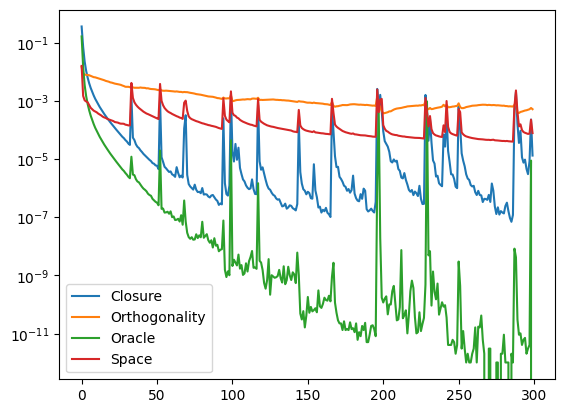

In [8]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [9]:
X, Y = next(iter(train_dataloader))
X = X.to(device)
X = model_AE.encoder(X).squeeze()
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


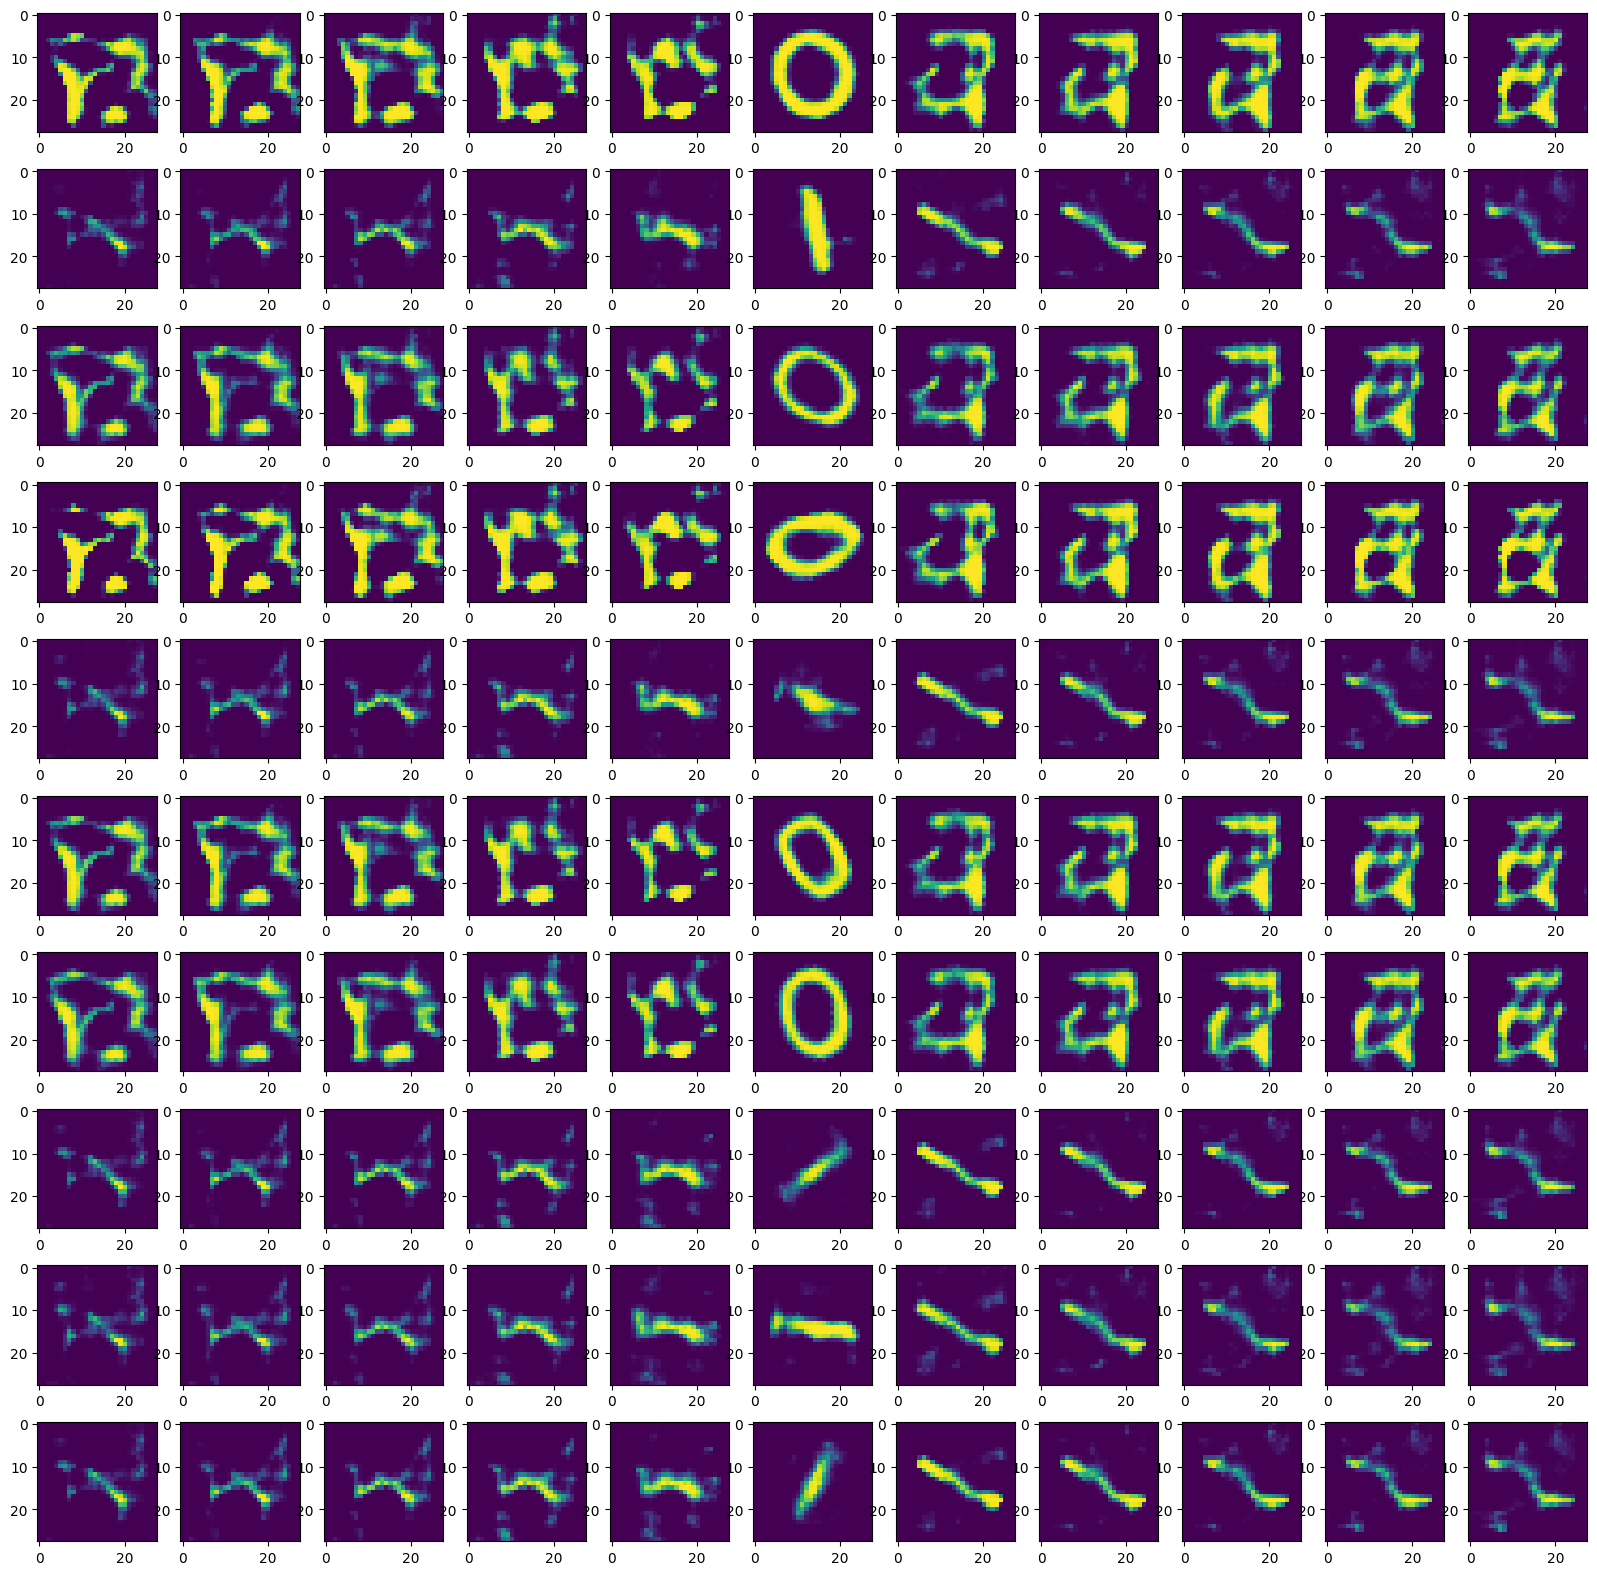

In [10]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_AE.decoder(model_fd(model_symmetry([theta*(step),zero,zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

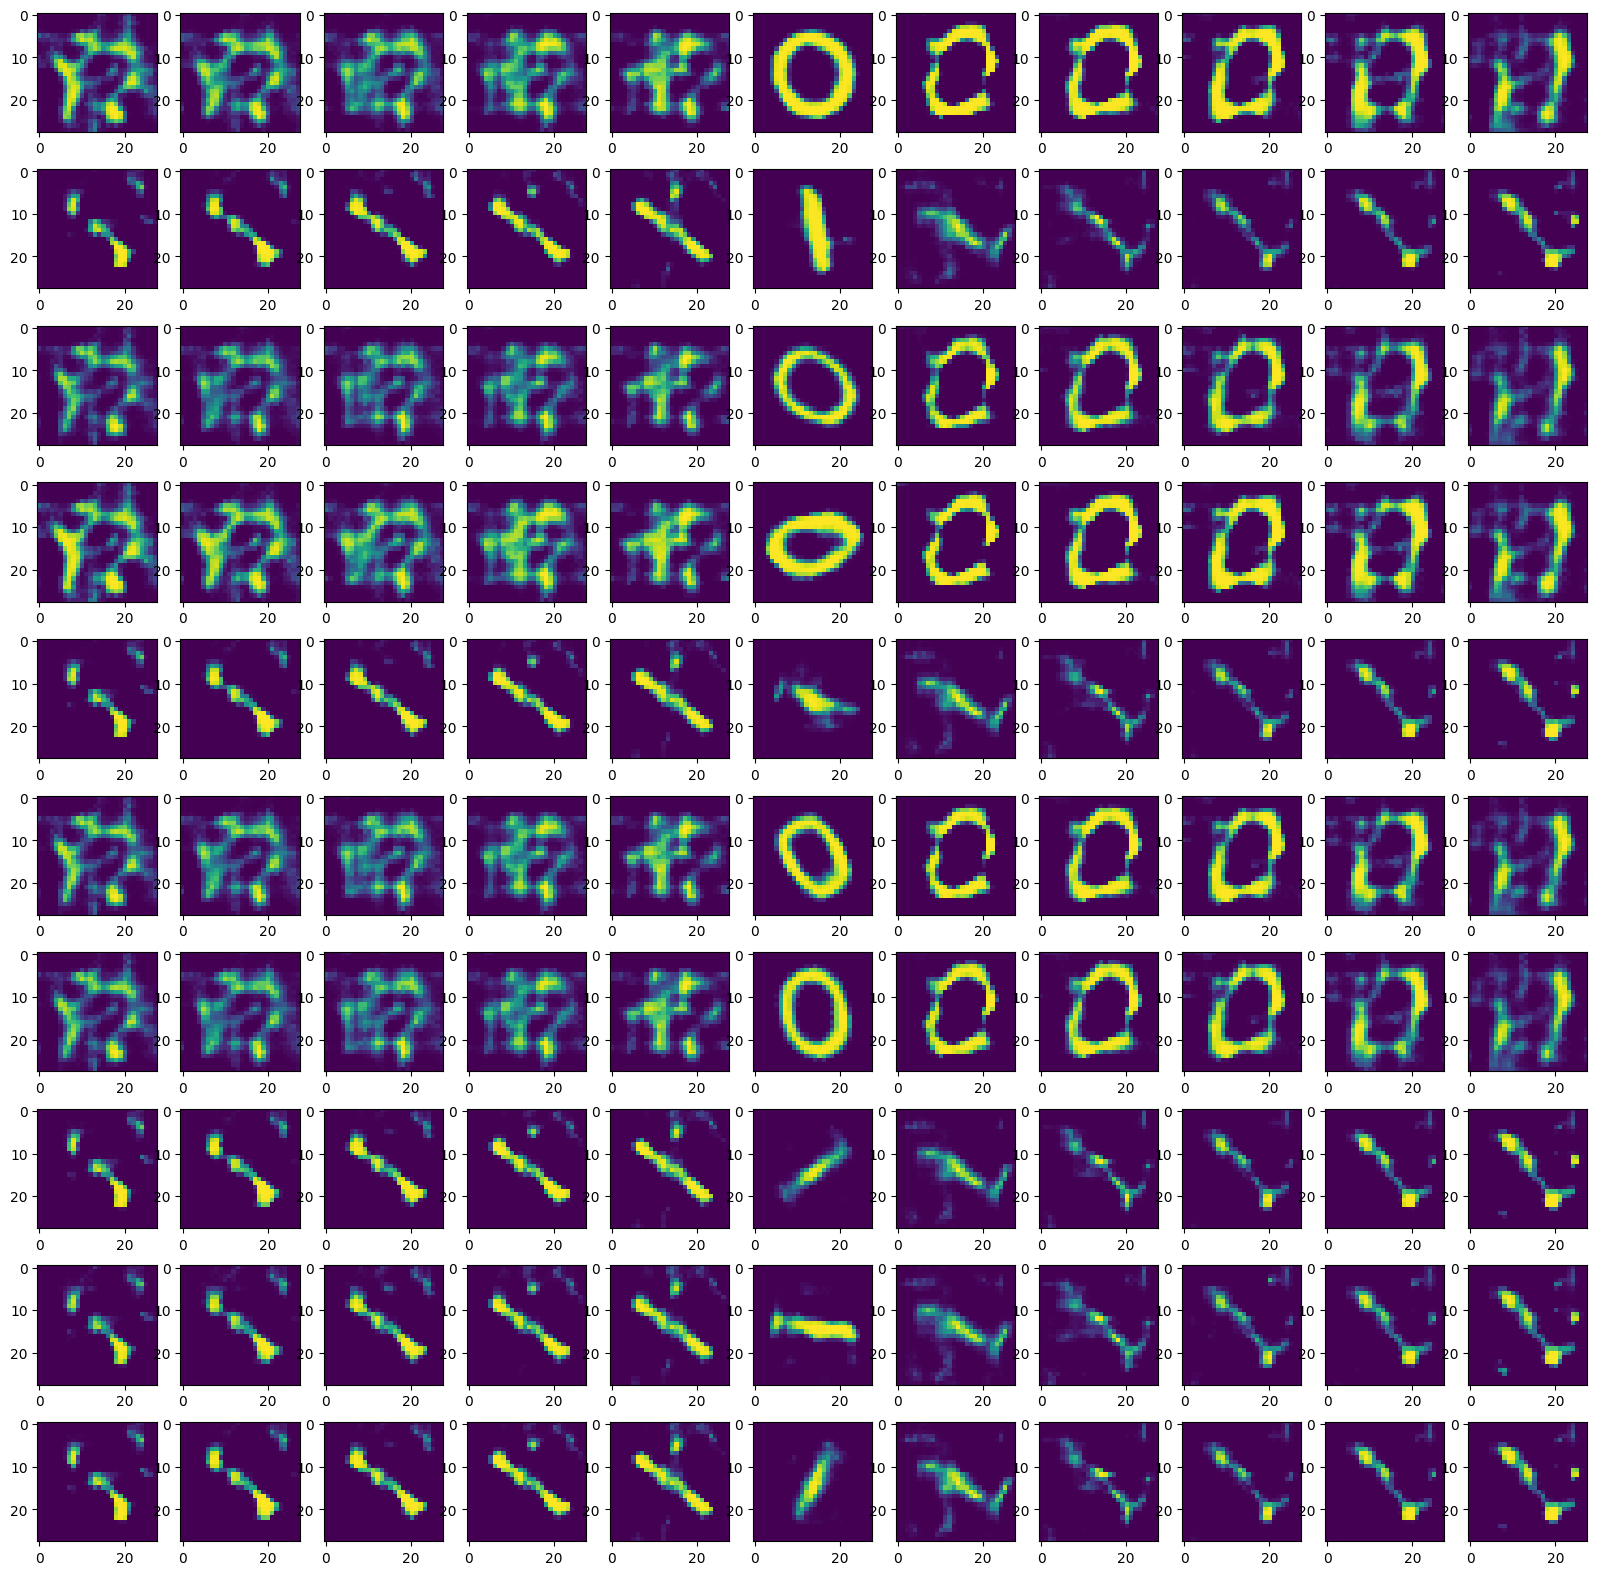

In [12]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_AE.decoder(model_fd(model_symmetry([zero,theta*(step),zero,zero,zero,zero,zero,zero,zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

In [ ]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step),zero,zero,zero,zero,zero,zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

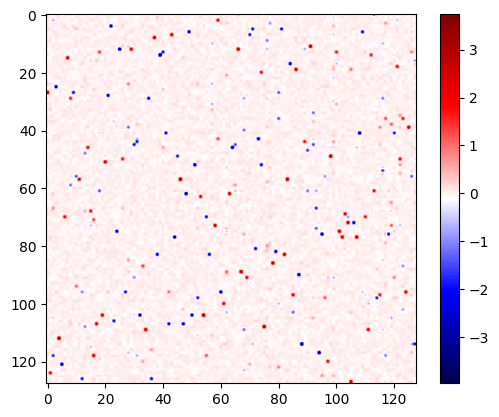

In [26]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

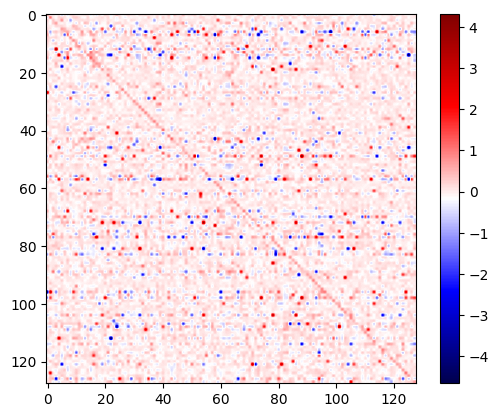

In [27]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

In [28]:
plt.imshow(model_symmetry.group[9].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

IndexError: index 9 is out of range

In [ ]:
plt.imshow(torch.matrix_exp(model_symmetry.group[9].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

In [ ]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

In [ ]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

# The symmetry could not be checked since the reconstruction of AE space is poor for random vectors, still the invariance and quality of symmetry has to be checked